__<div align='center'><font size='10'>Low Coverage Sequencing</font></div>__

In [1]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import csv
import matplotlib.colors as mcolors
from scipy.stats import poisson
import itertools
import collections

___Part1___

In [2]:
# Load code df
code = pd.read_csv('../data/lab_prep/P210354_sample-sheet.csv', skiprows=1, dtype = {'Sample/Well Location': 'string', 'Index Code': 'string'})
code = code.drop(columns = ['Sample/Name', 'Sample/LIMSID'])
code.columns = ['Location', 'Code']
# Load email df
email = pd.read_table('../data/lab_prep/email.txt', sep = ' ', header = None)
email = email.drop(columns = [0,2])
email.columns = ['Code', 'Num Reads']
email['Code'] = email['Code'].apply(lambda row: row.lstrip('WTCHG_904268_'))
email['Num Reads'] = email['Num Reads'].apply(lambda row: int(row.lstrip('Count:')))
# Load concentration df
f = open(r'../data/lab_prep/concentration.csv','r')
reader = csv.reader(f)
next(reader)
concentration = pd.DataFrame(reader)
concentration = concentration.loc[:,:6]
concentration.columns = concentration.iloc[0]
concentration = concentration[1:]
concentration = concentration.drop(columns = ['Sample ID', 'PoolNumber_original'])
for i in range(1, concentration.shape[1]):
    concentration.iloc[:,i] = pd.to_numeric(concentration.iloc[:,i])
# Load coverage df
coverage = pd.read_table('../results/per_base_coverage/per_base_coverage_all.txt', sep = ' ', header = None)
coverage.columns = ['Code', 'total', 'covered']
coverage['Code'] = coverage['Code'].apply(str)
coverage['percentage uncovered'] = 1-coverage['covered']/coverage['total']
coverage = coverage.drop(columns = ['total', 'covered'])
# Load dup rate df
dup_rate_fastqc = pd.read_csv('../results/fastqc/duplication_rate_fastqc.txt', header = None, names = ['Code', 'dup_rate_1', 'dup_rate_2'], sep = ' ',
                             dtype = {
        'Code': 'string',
        'dup_rate_1': 'float64',
        'dup_rate_2':'float64'
    })
dup_rate_fastqc['dup_rate_fastqc'] = 1 - (dup_rate_fastqc['dup_rate_1'] + dup_rate_fastqc['dup_rate_2'])/200
dup_rate_fastqc = dup_rate_fastqc.drop(columns = ['dup_rate_1', 'dup_rate_2'])
dup_rate_samtools = pd.read_csv('../results/duplication_rate/duplication_rate_samtools.txt', header = None, names = ['Code', 'total', 'dup_rate'], sep = ' ',
                             dtype = {
        'Code': 'string',
        'total': 'Int64',
        'dup_rate':'Int64'
    })
dup_rate_samtools['dup_rate_samtools'] = dup_rate_samtools['dup_rate']/dup_rate_samtools['total']
dup_rate_samtools = dup_rate_samtools.drop(columns = ['dup_rate', 'total'])
dup_rate = pd.merge(dup_rate_fastqc, dup_rate_samtools, on='Code', how="left")
# Merge all dataframe together    
lab_prep = pd.merge(concentration, code, on='Location', how="left")
lab_prep = pd.merge(lab_prep, email, on='Code', how="left")
lab_prep = pd.merge(lab_prep, coverage, on='Code', how="left")
lab_prep = pd.merge(lab_prep, dup_rate, on='Code', how='left')
lab_prep = lab_prep.drop(columns = ['Location'])
lab_prep = lab_prep.sort_values(by=['Num Reads'], ascending = False)
lab_prep['coverage'] = lab_prep['Num Reads']*(1-lab_prep['dup_rate_samtools'])*151*2/(3.2e9)
lab_prep.tail(20)

,Input. ng,lib conc_original,Conc_rpt PCR,# PCR cycles,Code,Num Reads,percentage uncovered,dup_rate_fastqc,dup_rate_samtools,coverage
39,3,0.0,0.65,14,72565232,14157220,0.458656,0.246580,0.3229,0.904665
12,300,6.6,6.96,10,72295205,14006676,0.374531,0.094802,0.098876,1.191177
67,196,3.8,3.82,10,72845260,13845496,0.370442,0.087765,0.093453,1.184557
46,1,0.1,1.18,14,72635239,13776796,0.424882,0.184967,0.254683,0.96905
7,300,7.7,8.24,10,72245200,13113900,0.393161,0.096577,0.112441,1.098465
22,300,4.5,4.78,10,72395215,12911004,0.378054,0.085060,0.102029,1.094156
19,300,6.1,6.49,10,72365212,12443302,0.402599,0.080981,0.092205,1.066057
79,-2,0.1,0.09,14,72005272,2757453,0.866423,0.289405,0.390337,0.158655
80,-2,-0.0,0.26,14,72015273,2629113,0.841256,0.159152,0.218443,0.193922
78,-3,0.1,0.02,14,71995271,1391974,0.926052,0.275360,0.371836,0.08252


In [3]:
lab_prep_high_input = lab_prep[lab_prep['# PCR cycles'] == 10]
lab_prep_low_input = lab_prep[lab_prep['# PCR cycles'] == 14]
lab_prep_NA12878 = lab_prep[lab_prep['Code'] == '72155287']

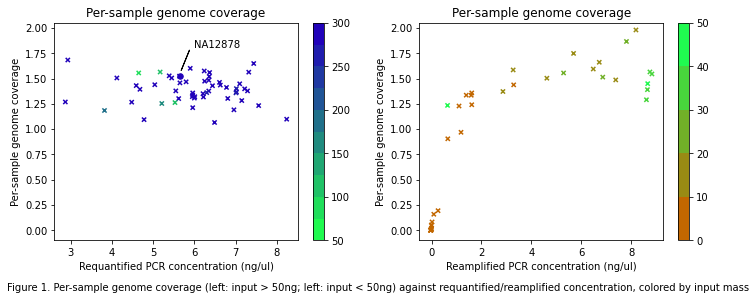

In [146]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)
bounds1 = np.linspace(50, 300, 11)
colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
im1 = ax1.scatter(lab_prep_high_input['Conc_rpt PCR'][4:], lab_prep_high_input['coverage'][4:], 
                  c=lab_prep_high_input['Input. ng'][4:], cmap=cmap1, norm=norm1, s=18, marker = "x")
ax1.scatter(lab_prep_NA12878['Conc_rpt PCR'], lab_prep_NA12878['coverage'], 
                  c=lab_prep_NA12878['Input. ng'], cmap=cmap1, norm=norm1, s=30, marker = "o")
ax1.set_xlabel('Requantified PCR concentration (ng/ul)')
ax1.set_ylabel('Per-sample genome coverage')
ax1.set_title('Per-sample genome coverage')
ax1.set_ylim((-0.1,2.05))
ax1.arrow(x=5.68, y=1.58, dx=0.2, dy=0.2)
ax1.text(x=6.0, y=1.8, s='NA12878')
fig.colorbar(im1, boundaries=bounds1)

ax2 = plt.subplot(1, 2, 2)
bounds2 = np.linspace(0, 50, 6)
colors2 = ['#c26700', '#998b14', '#71b028', '#48d53c', '#20fa50']
cmap2 = mcolors.ListedColormap(colors2)
norm2 = mcolors.BoundaryNorm(bounds2, cmap2.N)
im2 = ax2.scatter(lab_prep_low_input['Conc_rpt PCR'], lab_prep_low_input['coverage'], 
                  c = lab_prep_low_input['Input. ng'], cmap=cmap2, norm=norm2, s=18, marker = 'x')
ax2.set_xlabel('Reamplified PCR concentration (ng/ul)')
ax2.set_ylabel('Per-sample genome coverage')
ax2.set_title('Per-sample genome coverage')
ax2.set_ylim((-0.1,2.05))
fig.colorbar(im2, boundaries=bounds2)
plt.figtext(.5, -0.05, 'Figure 1. Per-sample genome coverage (left: input > 50ng; left: input < 50ng) against requantified/reamplified concentration, colored by input mass', ha='center')
plt.savefig('../graphs/fig1_per_sample_coverage_vs_concentration.png', bbox_inches = "tight", dpi=300)
plt.show()

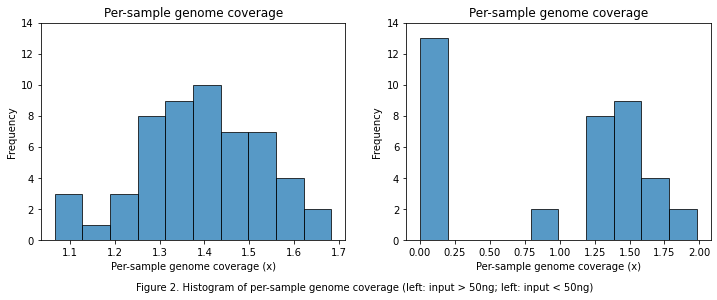

In [147]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(lab_prep_high_input['coverage'][4:], alpha=0.75, histtype='bar', ec='black')
plt.xlabel('Per-sample genome coverage (x)')
plt.ylabel('Frequency')
plt.ylim((0,14))
plt.title('Per-sample genome coverage')

plt.subplot(1, 2, 2)
plt.hist(lab_prep_low_input['coverage'], alpha=0.75, histtype='bar', ec='black')
plt.xlabel('Per-sample genome coverage (x)')
plt.ylabel('Frequency')
plt.ylim((0,14))
plt.title('Per-sample genome coverage')
plt.figtext(.5, -0.05, 'Figure 2. Histogram of per-sample genome coverage (left: input > 50ng; left: input < 50ng)', ha='center')
plt.savefig('../graphs/fig2_per_sample_coverage_histogram.png', bbox_inches = "tight", dpi=300)
plt.show()

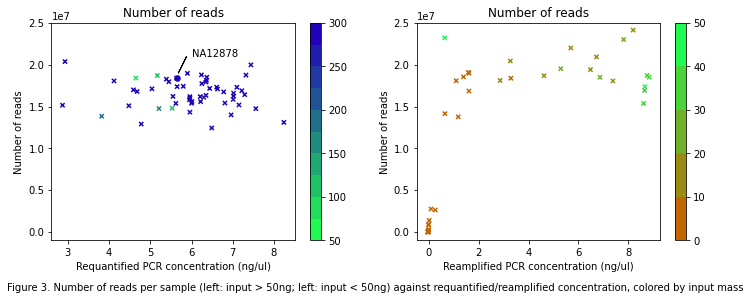

In [148]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)
bounds1 = np.linspace(50, 300, 11)
colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
im1 = ax1.scatter(lab_prep_high_input['Conc_rpt PCR'][4:], lab_prep_high_input['Num Reads'][4:], c = lab_prep_high_input['Input. ng'][4:], 
                  cmap=cmap1, norm=norm1, s=18, marker = "x")
ax1.scatter(lab_prep_NA12878['Conc_rpt PCR'], lab_prep_NA12878['Num Reads'], c=lab_prep_NA12878['Input. ng'], 
            cmap=cmap1, norm=norm1, s=30, marker = "o")
ax1.set_xlabel('Requantified PCR concentration (ng/ul)')
ax1.set_ylabel('Number of reads')
ax1.set_title('Number of reads')
ax1.set_ylim((-1e6,2.5e7))
ax1.arrow(x=5.68, y=1.9e7, dx=0.2, dy=2e6)
ax1.text(x=6.0, y=2.1e7, s='NA12878')
fig.colorbar(im1, boundaries=bounds1)

ax2 = plt.subplot(1, 2, 2)
bounds2 = np.linspace(0, 50, 6)
colors2 = ['#c26700', '#998b14', '#71b028', '#48d53c', '#20fa50']
cmap2 = mcolors.ListedColormap(colors2)
norm2 = mcolors.BoundaryNorm(bounds2, cmap2.N)
im2 = ax2.scatter(lab_prep_low_input['Conc_rpt PCR'], lab_prep_low_input['Num Reads'], c = lab_prep_low_input['Input. ng'], 
                  cmap=cmap2, norm=norm2, s=18, marker = 'x')
ax2.set_xlabel('Reamplified PCR concentration (ng/ul)')
ax2.set_ylabel('Number of reads')
ax2.set_title('Number of reads')
ax2.set_ylim((-1e6,2.5e7))
fig.colorbar(im2, boundaries=bounds2)
plt.figtext(.5, -0.05, 'Figure 3. Number of reads per sample (left: input > 50ng; left: input < 50ng) against requantified/reamplified concentration, colored by input mass', ha='center')
plt.savefig('../graphs/fig3_number_reads_vs_concentration.png', bbox_inches = "tight", dpi=300)
plt.show()

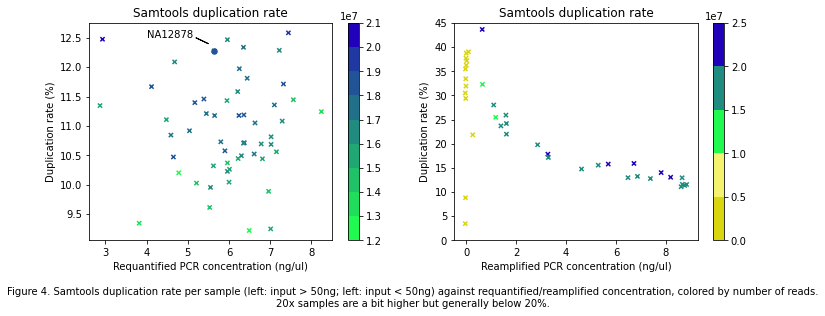

In [149]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)
bounds1 = np.linspace(1.2e7, 2.1e7, 10)
colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#2102ba']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
im1 = ax1.scatter(lab_prep_high_input['Conc_rpt PCR'][4:], lab_prep_high_input['dup_rate_samtools'][4:]*100, c=lab_prep_high_input['Num Reads'][4:], 
                  cmap=cmap1, norm=norm1, s=18, marker = "x")
ax1.scatter(lab_prep_NA12878['Conc_rpt PCR'], lab_prep_NA12878['dup_rate_samtools']*100, c=lab_prep_NA12878['Num Reads'], 
            cmap=cmap1, norm=norm1, s=30, marker = "o")
ax1.set_xlabel('Requantified PCR concentration (ng/ul)')
ax1.set_ylabel('Duplication rate (%)')
ax1.set_title('Samtools duplication rate')
ax1.arrow(x=5.5, y=12.4, dx=-0.3, dy=0.1)
ax1.text(x=4, y=12.5, s='NA12878')
fig.colorbar(im1, boundaries=bounds1)

ax2 = plt.subplot(1, 2, 2)
bounds2 = np.linspace(0, 2.5e7, 6)
colors2 = ['#d9d50f', '#f5f36e', '#20fa50', '#208b7f', '#2102ba']
cmap2 = mcolors.ListedColormap(colors2)
norm2 = mcolors.BoundaryNorm(bounds2, cmap2.N)
im2 = ax2.scatter(lab_prep_low_input['Conc_rpt PCR'], lab_prep_low_input['dup_rate_samtools']*100, c=lab_prep_low_input['Num Reads'], 
                  cmap=cmap2, norm=norm2, s=18, marker = 'x')
ax2.set_xlabel('Reamplified PCR concentration (ng/ul)')
ax2.set_ylabel('Duplication rate (%)')
ax2.set_title('Samtools duplication rate')
ax2.set_ylim((0, 45))
fig.colorbar(im2, boundaries=bounds2)
plt.figtext(.5, -0.1, 
            'Figure 4. Samtools duplication rate per sample (left: input > 50ng; left: input < 50ng) against requantified/reamplified concentration, colored by number of reads.\n20x samples are a bit higher but generally below 20%.', ha='center', wrap = True)
plt.savefig('../graphs/fig4_duplication_rate_vs_concentration.png', bbox_inches = "tight", dpi=300)
plt.show()

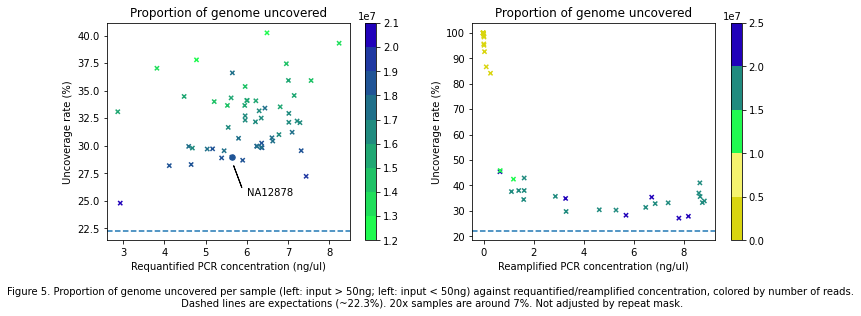

In [150]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)
bounds1 = np.linspace(1.2e7, 2.1e7, 10)
colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#2102ba']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
im1 = ax1.scatter(lab_prep_high_input['Conc_rpt PCR'][4:], lab_prep_high_input['percentage uncovered'][4:]*100, c=lab_prep_high_input['Num Reads'][4:], 
                  cmap=cmap1, norm=norm1, s=18, marker = "x")
ax1.scatter(lab_prep_NA12878['Conc_rpt PCR'], lab_prep_NA12878['percentage uncovered']*100, c=lab_prep_NA12878['Num Reads'], 
            cmap=cmap1, norm=norm1, s=30, marker = "o")
ax1.axhline(y=22.3, ls = '--')
ax1.set_xlabel('Requantified PCR concentration (ng/ul)')
ax1.set_ylabel('Uncoverage rate (%)')
ax1.set_title('Proportion of genome uncovered')
ax1.arrow(x=5.68, y=28.2, dx=0.2, dy=-2)
ax1.text(x=6.0, y=25.5, s='NA12878')
fig.colorbar(im1, boundaries=bounds1)

ax2 = plt.subplot(1, 2, 2)
bounds2 = np.linspace(0, 2.5e7, 6)
colors2 = ['#d9d50f', '#f5f36e', '#20fa50', '#208b7f', '#2102ba']
cmap2 = mcolors.ListedColormap(colors2)
norm2 = mcolors.BoundaryNorm(bounds2, cmap2.N)
im2 = ax2.scatter(lab_prep_low_input['Conc_rpt PCR'], lab_prep_low_input['percentage uncovered']*100, c=lab_prep_low_input['Num Reads'], 
                  cmap=cmap2, norm=norm2, s=18, marker = 'x')
ax2.axhline(y=22.3, ls = '--')
ax2.set_xlabel('Reamplified PCR concentration (ng/ul)')
ax2.set_ylabel('Uncoverage rate (%)')
ax2.set_title('Proportion of genome uncovered')
fig.colorbar(im2, boundaries=bounds2)
plt.figtext(.5, -0.1, 
            'Figure 5. Proportion of genome uncovered per sample (left: input > 50ng; left: input < 50ng) against requantified/reamplified concentration, colored by number of reads.\n Dashed lines are expectations (~22.3%). 20x samples are around 7%. Not adjusted by repeat mask.', ha='center', wrap = True)
plt.savefig('../graphs/fig5_uncoverage_rate_vs_concentration.png', bbox_inches = "tight", dpi=300)
plt.show()

/tmp/ipykernel_105139/3758761501.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3, 1, figsize = (12,15), gridspec_kw={'height_ratios': [5, 5, 1]})


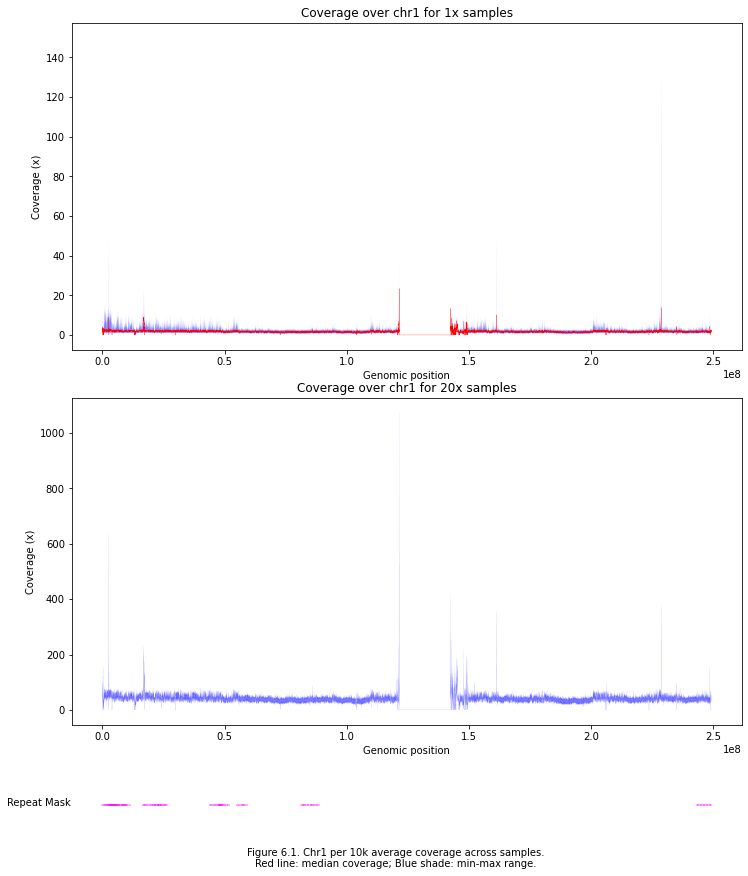

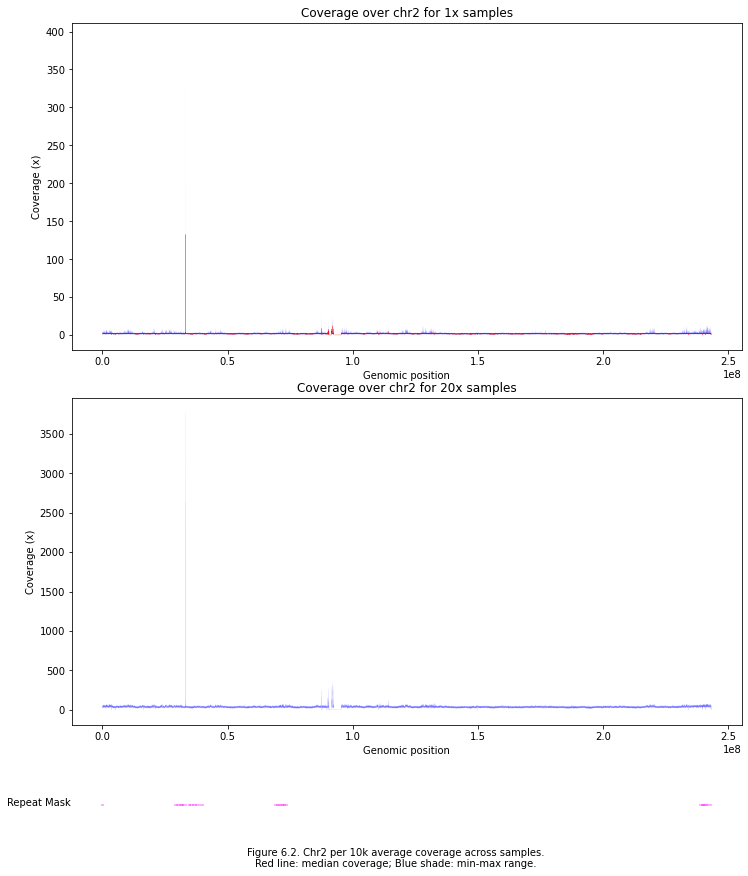

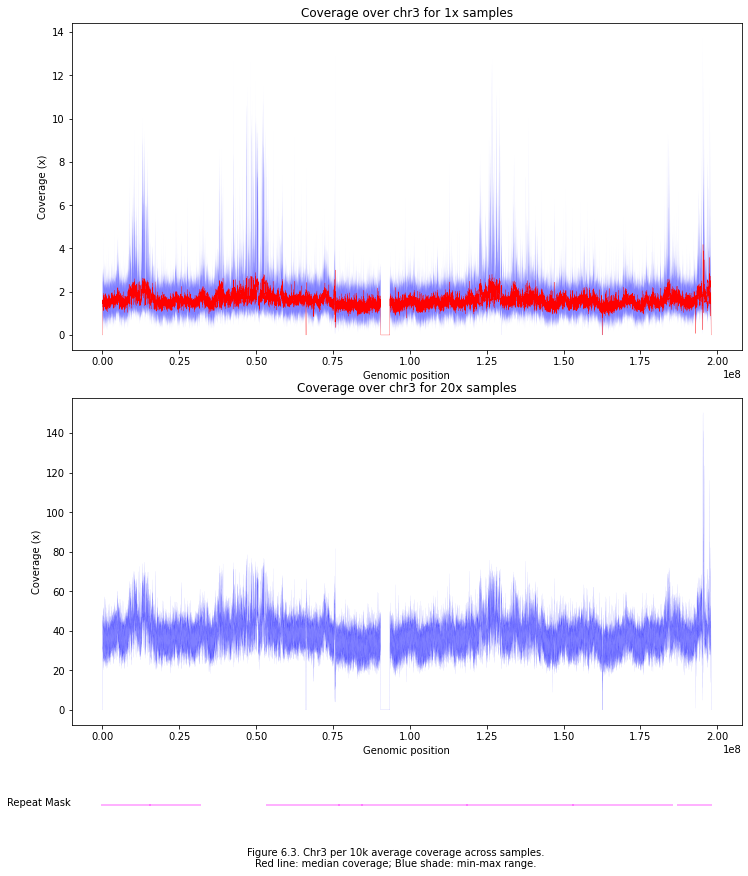

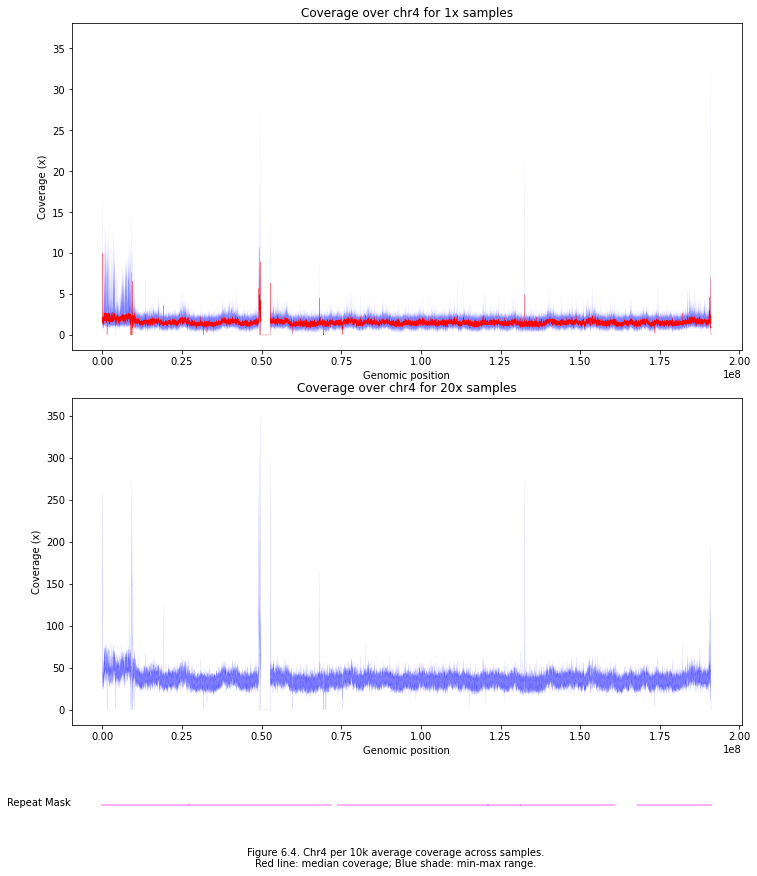

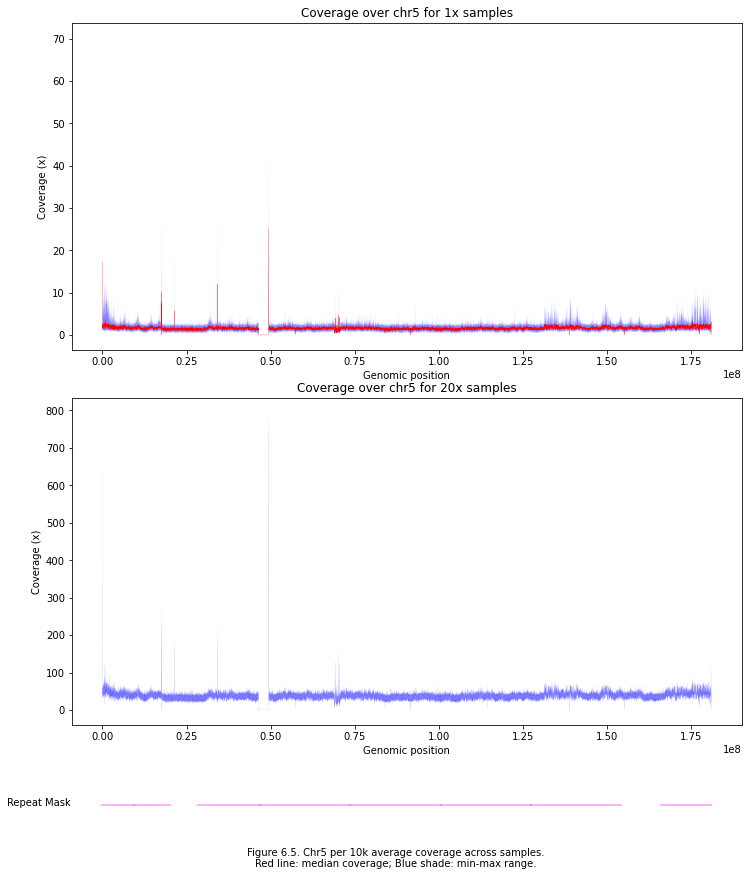

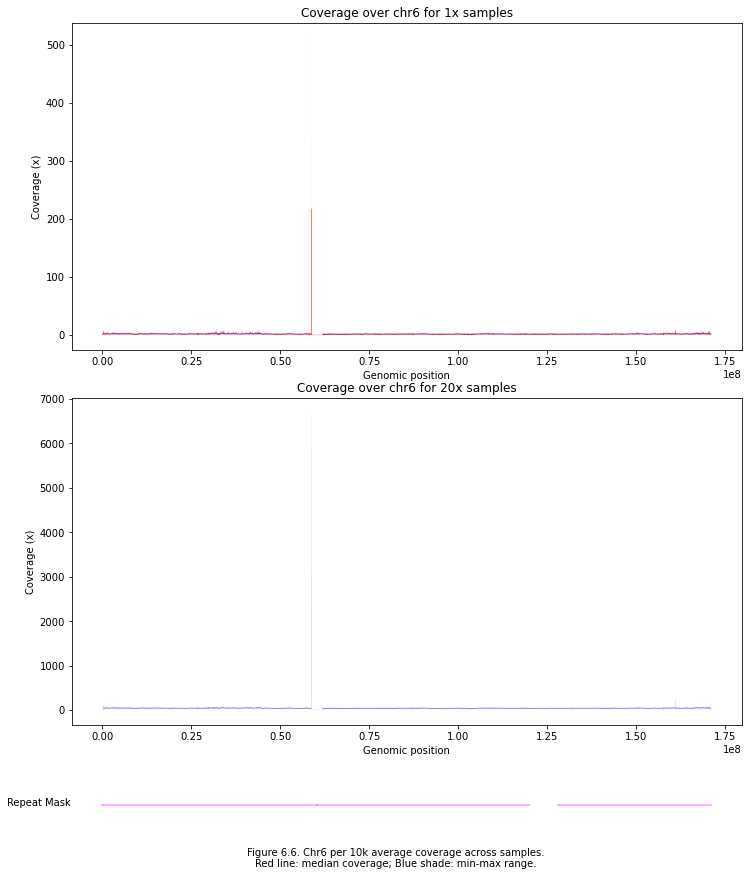

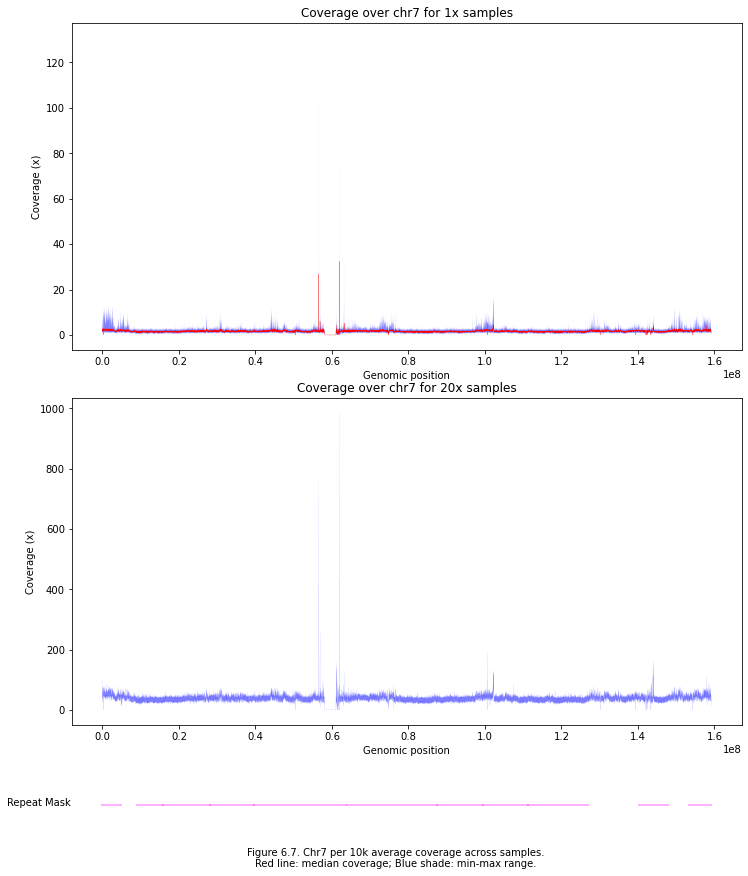

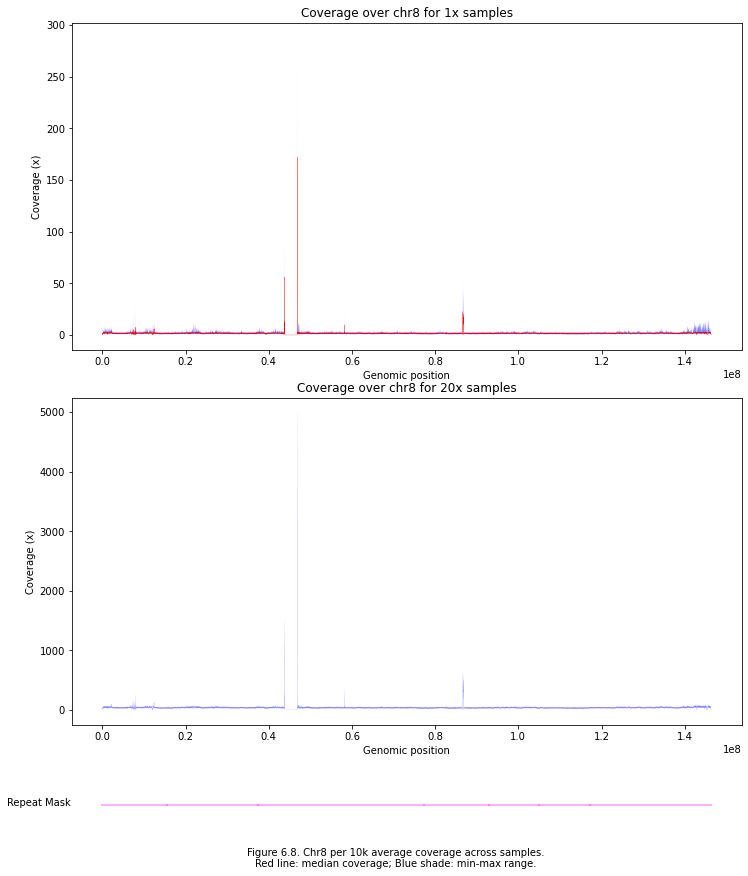

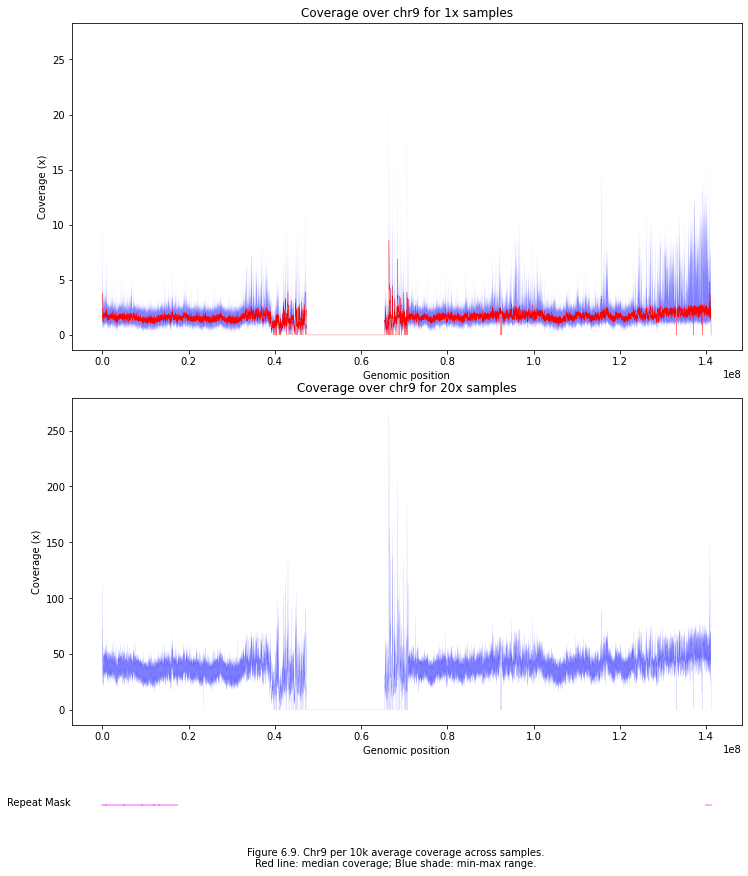

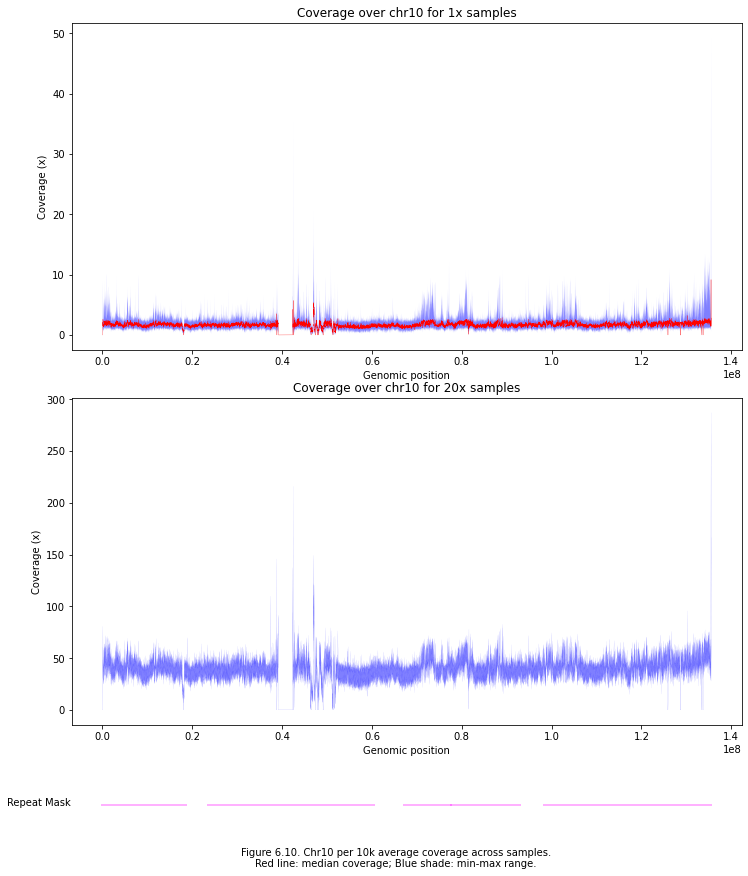

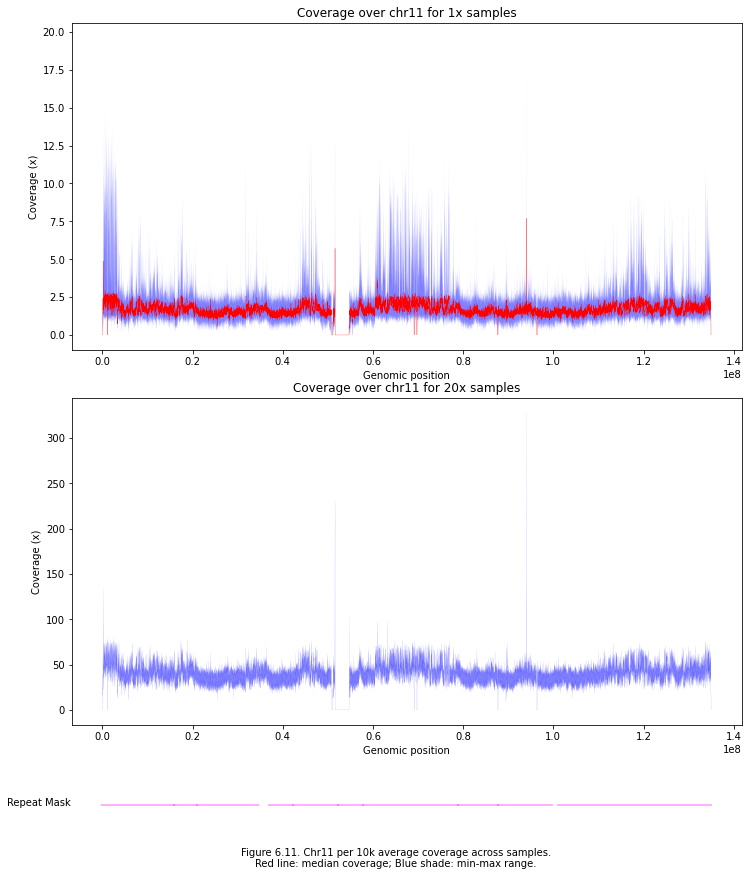

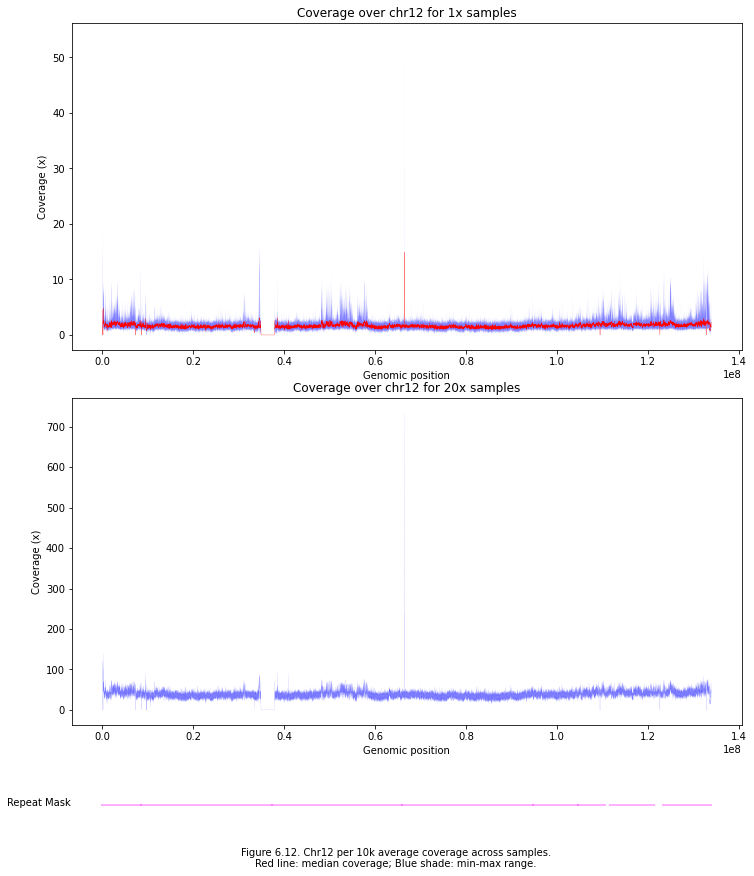

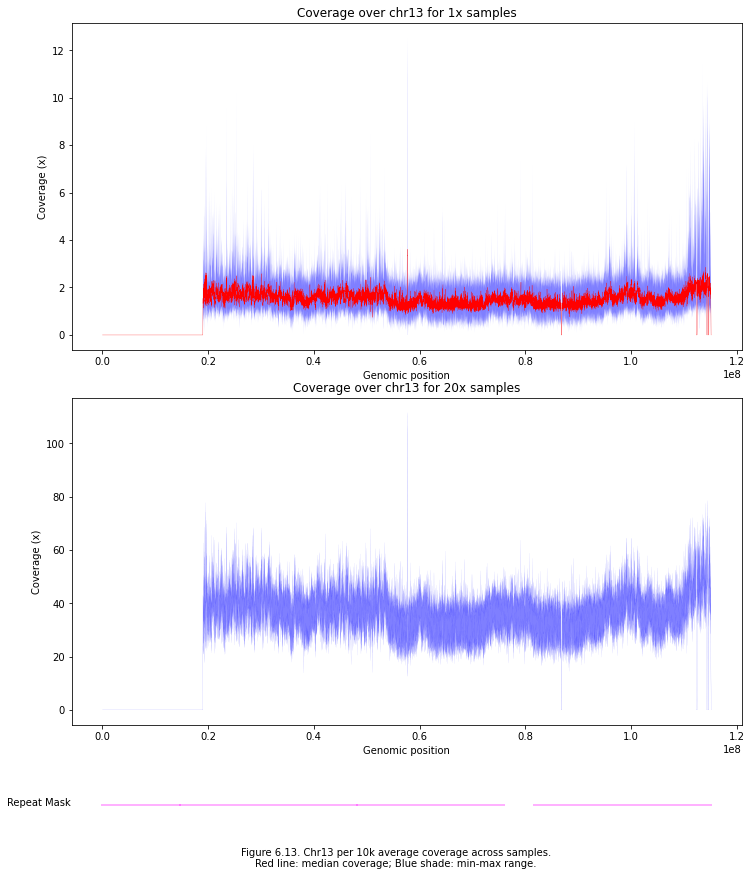

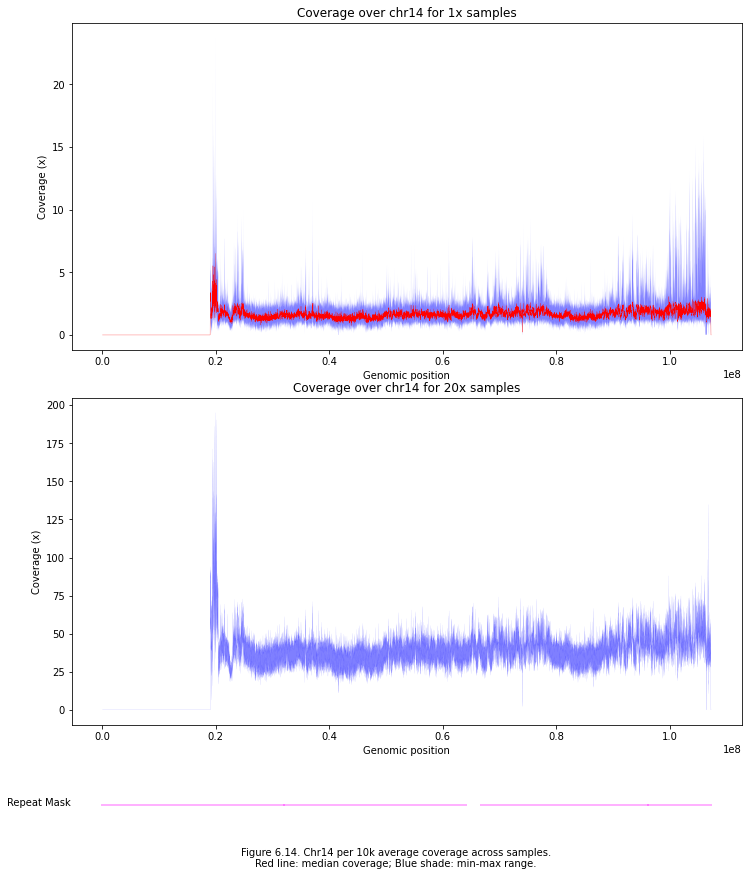

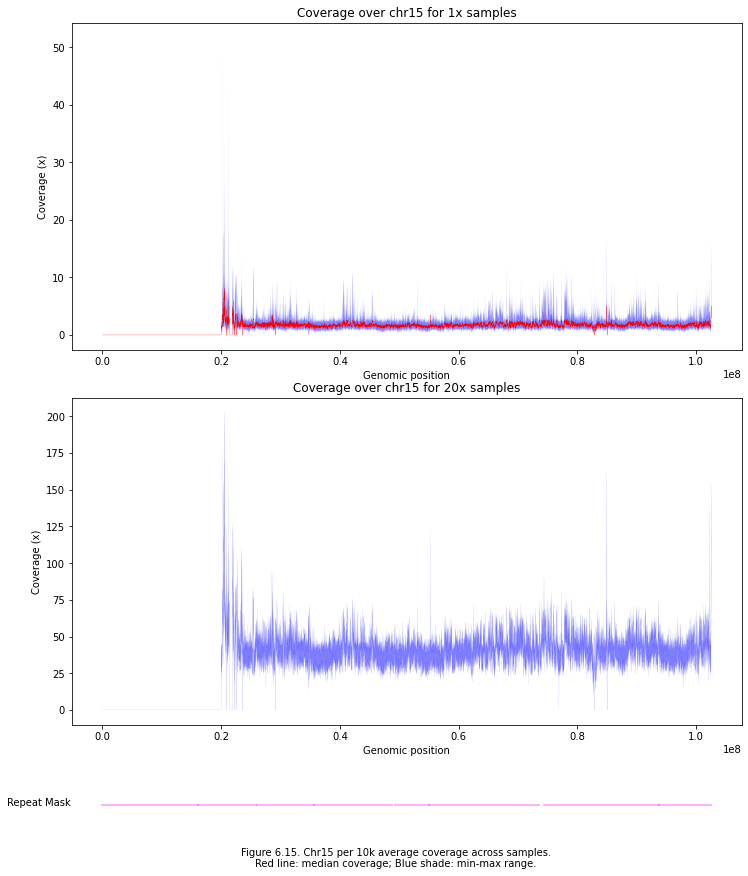

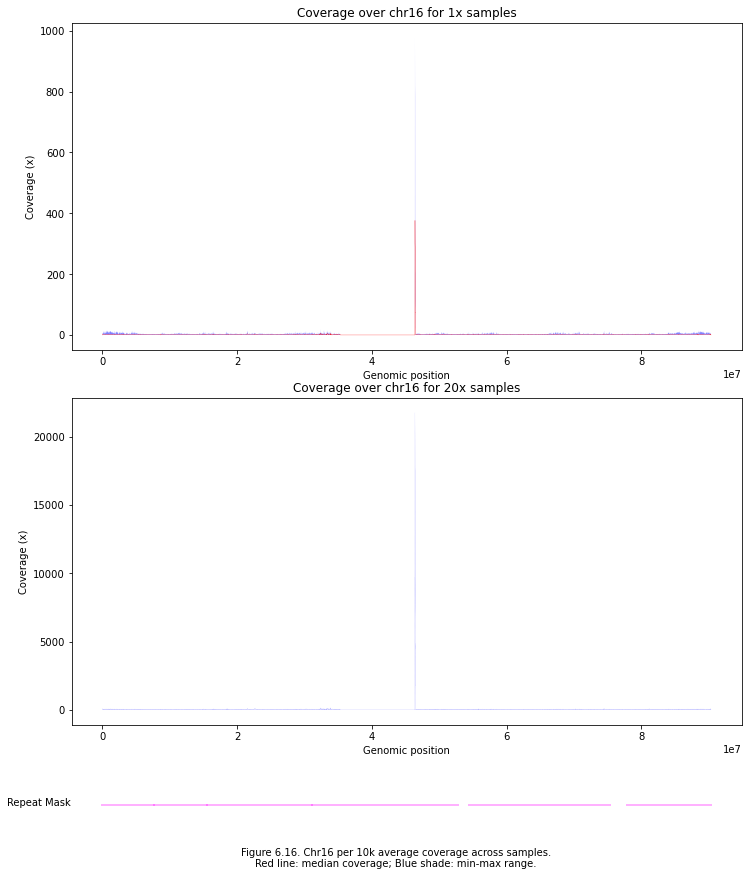

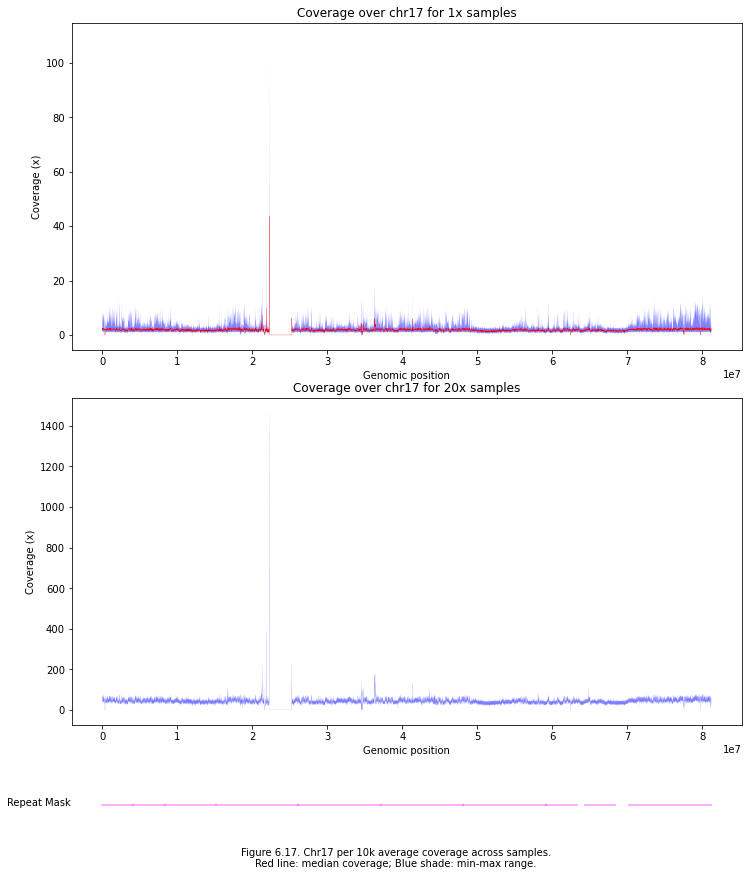

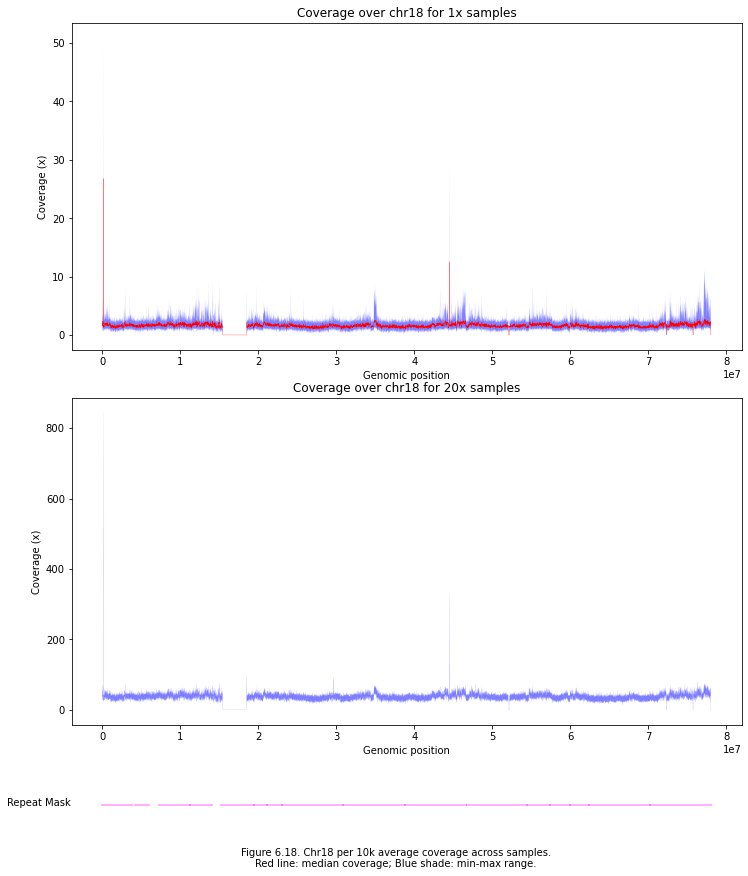

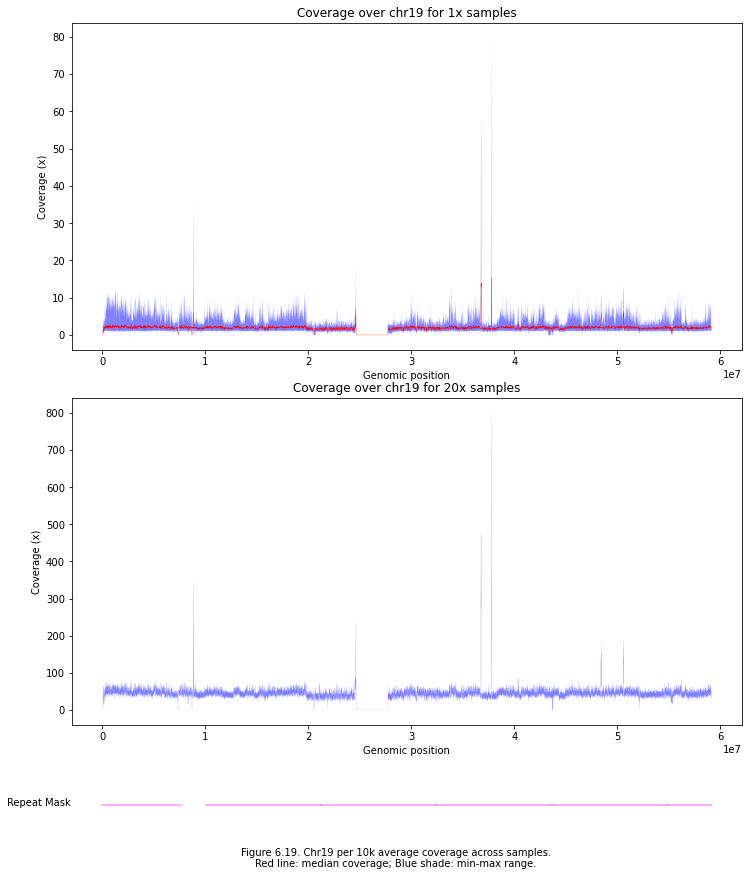

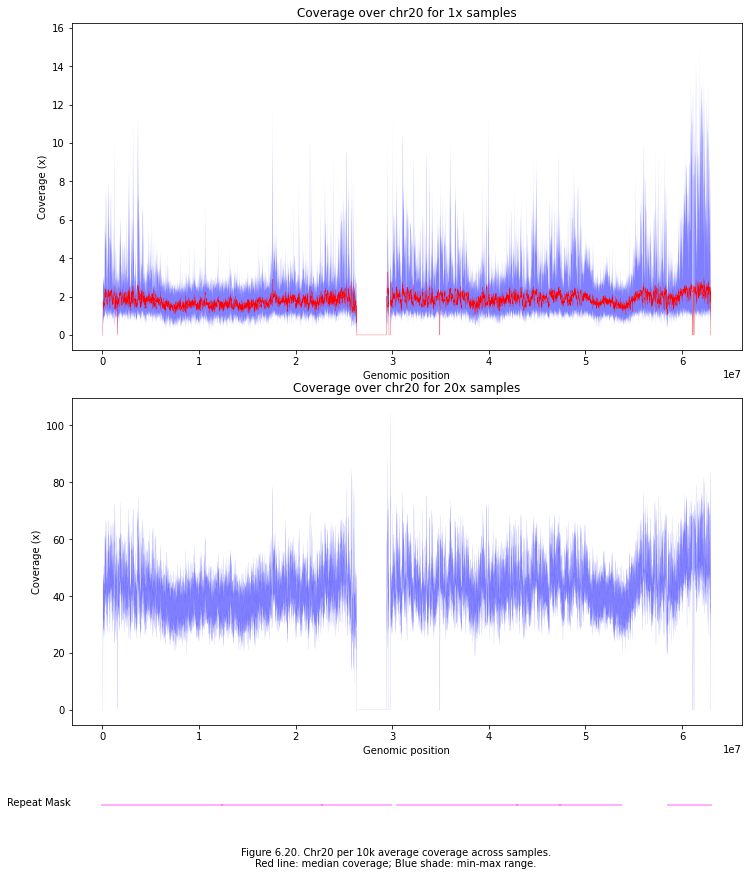

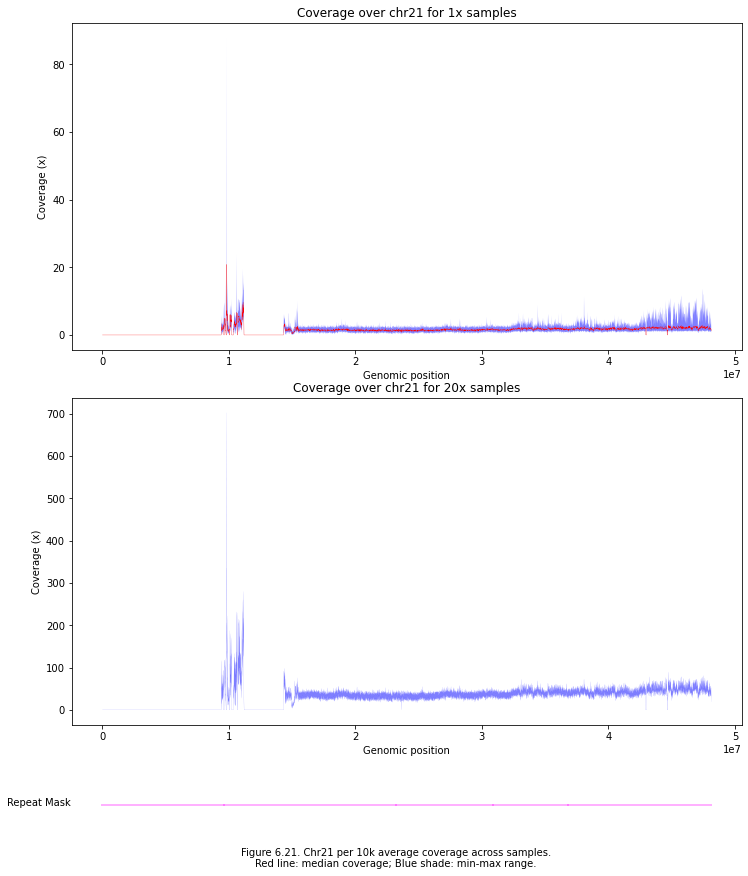

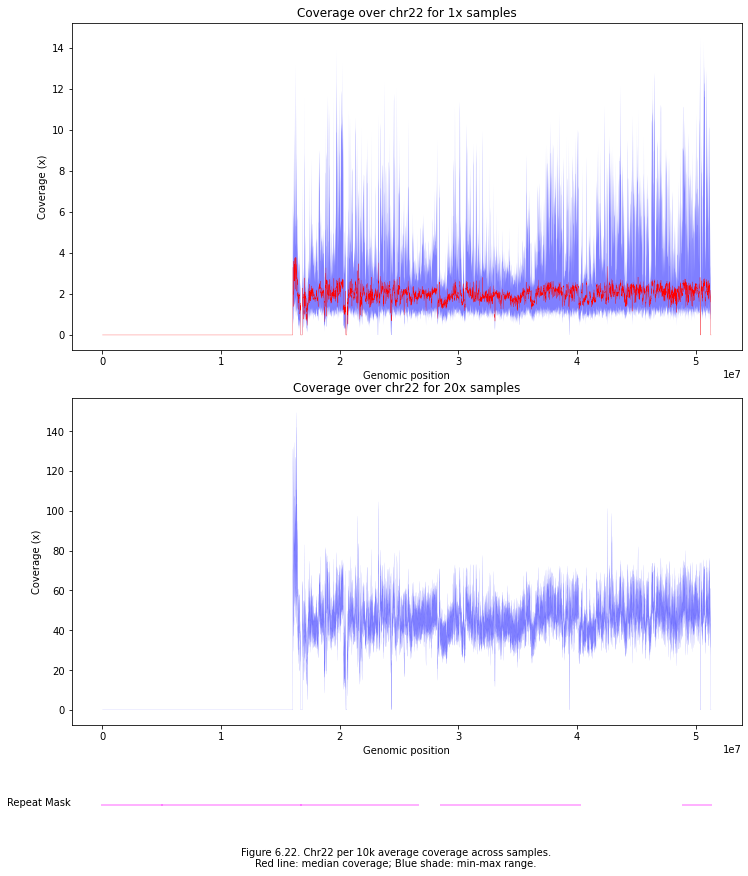

In [4]:
import glob
for i in range(1,23):
    path = "../results/per_base_coverage/per_bin_coverage_10000/*chr" + str(i) + "_base.txt"
    for filename in glob.glob(path):
        rstrip = '_chr' + str(i) +'_base.txt'
        code = filename.replace(rstrip, "").replace('../results/per_base_coverage/per_bin_coverage_10000/', '')
        if code not in ['72105282', '72115283', '72125284', '72135285', '72005272', '72015273', '71995271', '72025274', '71955267', '72555231', '72885264', '72545230', '72055277', '71975269', '72075279', '72165288', '72145286']:
            tmp = np.loadtxt(filename)
            if 'per_bins_coverage_low' not in locals(): # Check if this variable is defined or not
                per_bins_coverage_low = tmp
            else:
                per_bins_coverage_low = np.vstack([per_bins_coverage_low, tmp])
        elif code not in ['72005272', '72015273', '71995271', '72025274', '71955267', '72555231', '72885264', '72545230', '72055277', '71975269', '72075279', '72165288', '72145286']:
            tmp = np.loadtxt(filename)
            if 'per_bins_coverage_high' not in locals():
                per_bins_coverage_high = tmp
            else:
                per_bins_coverage_high = np.vstack([per_bins_coverage_high, tmp])
                
    repeat_mask = pd.read_csv('../results/per_base_coverage/repeat_mask_region_by_chromosome/repeat_mask_chr' + str(i) + '_region.txt', header = None, names = ['start', 'end'], sep = '\t',
                             dtype = {
        'start': 'Int64',
        'end': 'Int64'
    })
    repeat_mask['length'] = repeat_mask['end'] - repeat_mask['start']
    repeat_mask_bin_size = 1e5
    repeat_mask = repeat_mask[repeat_mask['length'] >= repeat_mask_bin_size]
        
    coordinate_ary = np.loadtxt("../results/per_base_coverage/per_bin_coverage_10000/71935265_chr" + str(i) + "_coordinate.txt")
    max_ary_low = per_bins_coverage_low.max(axis=0)
    median_ary_low = np.median(per_bins_coverage_low, axis=0)
    min_ary_low = per_bins_coverage_low.min(axis=0)
    
    max_ary_high = per_bins_coverage_high.max(axis=0)
    median_ary_high = np.median(per_bins_coverage_high, axis=0)
    min_ary_high = per_bins_coverage_high.min(axis=0)
    
    if i == 1:
        median_ary_low_aggregate = median_ary_low
        median_ary_high_aggregate = median_ary_high
    else:
        median_ary_low_aggregate = np.hstack([median_ary_low_aggregate, median_ary_low])
        median_ary_high_aggregate = np.hstack([median_ary_high_aggregate, median_ary_high])
        
    fig, ax = plt.subplots(3, 1, figsize = (12,15), gridspec_kw={'height_ratios': [5, 5, 1]})
    ax[0].plot(coordinate_ary, median_ary_low, linewidth=0.25, color = 'red')
    ax[0].fill_between(coordinate_ary, min_ary_low, max_ary_low, alpha = 0.5, color = 'blue', ec = None)
    ax[0].set_ylabel('Coverage (x)')
    ax[0].set_title('Coverage over chr' + str(i) + ' for 1x samples')
    ax[0].set_xlabel('Genomic position')
    
    ax[1].plot(coordinate_ary, min_ary_high, linewidth=0.03, color = 'blue')
    ax[1].plot(coordinate_ary, max_ary_high, linewidth=0.03, color = 'blue')
    ax[1].fill_between(coordinate_ary, min_ary_high, max_ary_high, alpha = 0.5, color = 'blue', ec = None)
    ax[1].set_ylabel('Coverage (x)')
    ax[1].set_title('Coverage over chr' + str(i) + ' for 20x samples')
    ax[1].set_xlabel('Genomic position')
    
    for j in range(repeat_mask.shape[0]):
        ax[2].plot(repeat_mask.iloc[j,:2].values, -5*np.ones(2), color='magenta', linewidth=2, alpha=0.3)
    ax[2].axis('off')
    plt.figtext(0.05, 0.155, 'Repeat Mask')
    plt.figtext(.5, 0.1, 
                'Figure 6.' + str(i) +'. Chr' + str(i) +' per 10k average coverage across samples.\nRed line: median coverage; Blue shade: min-max range.', ha='center', wrap = True)
    plt.savefig('../graphs/coverage_chr' + str(i) +'.png', bbox_inches = "tight", dpi=300)
    del per_bins_coverage_low, per_bins_coverage_high

9.711298576459986e-01


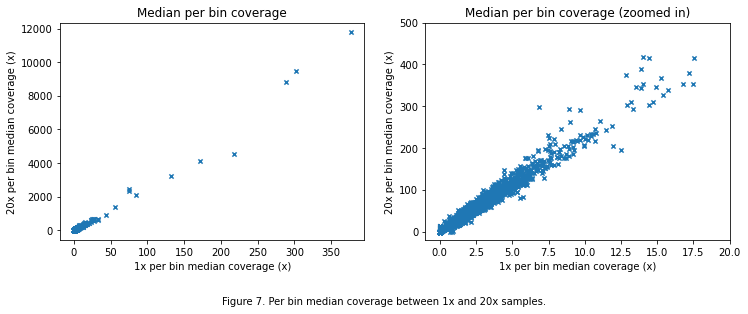

In [10]:
print(np.corrcoef(median_ary_low_aggregate, median_ary_high_aggregate)[0,1]**2)

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)

ax1.scatter(median_ary_low_aggregate, median_ary_high_aggregate, s=18, marker = 'x')
ax1.set_xlabel('1x per bin median coverage (x)')
ax1.set_ylabel('20x per bin median coverage (x)')
ax1.set_title('Median per bin coverage')

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(median_ary_low_aggregate, median_ary_high_aggregate, s=18, marker = 'x')
ax2.set_xlabel('1x per bin median coverage (x)')
ax2.set_ylabel('20x per bin median coverage (x)')
ax2.set_title('Median per bin coverage (zoomed in)')
ax2.set_xlim((-1,20))
ax2.set_ylim((-20,500))

plt.figtext(.5, -0.1, 
            'Figure 7. Per bin median coverage between 1x and 20x samples.', ha='center', wrap = True)
plt.savefig('../graphs/fig7_20x_per_bin_coverage_vs_1x_per_bin_coverage.png', bbox_inches = "tight", dpi=300)
plt.show()

In [4]:
lab_prep_cov = lab_prep[(lab_prep['coverage'] > 1) & (lab_prep['coverage'] < 20)].sort_values(by = ['coverage'])
lab_prep_cov['Num Simulation'] = (lab_prep_cov['Num Reads']*(1-lab_prep_cov['dup_rate_samtools']) - 3.2e9/(151*2)) // 1
lab_prep_cov['Downsample Rate'] = (3.2e9/(151*2))/lab_prep_cov['Num Reads']
lab_prep_cov[['Code', 'Downsample Rate']].to_csv('../results/per_base_coverage/downsample/downsample_rate.txt', sep = '\t', index = False)

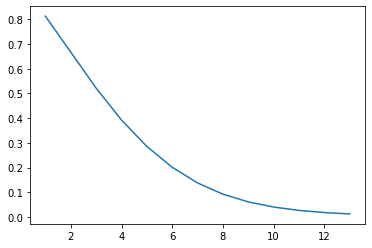

In [18]:
df = pd.read_csv('../results/per_base_coverage/per_base_coverage_compact/test.txt', header = None, sep = '\t', 
                 names = ['chr', 'start', 'end', 'cov'],
                dtype = {
                    'chr': 'string',
                    'start': 'Int64',
                    'end': 'Int64',
                    'cov': 'Int64'
                })
df = df[df.chr.isin([str(i) for i in range(1,23)] + ['chr' + str(i) for i in range(1,23)])]
df['bases'] = df['end'] - df['start']
df = df.groupby(['cov']).bases.sum().reset_index()
df['prop bases'] = df['bases']/df.bases.sum()
df['cum prop'] = np.cumsum(df['prop bases'].to_numpy())
df['prop genome at least covered'] = (1-df['cum prop'].shift(1))
df = df.dropna()
df = df[df['prop genome at least covered'] > 0.01]
df = df.drop(columns = ['cum prop', 'prop bases', 'bases'])

plt.plot(df['cov'], df['prop genome at least covered'])


In [19]:
df

,cov,prop genome at least covered
1,1,0.812097
2,2,0.666908
3,3,0.521151
4,4,0.392192
5,5,0.285398
6,6,0.201006
7,7,0.137719
8,8,0.092291
9,9,0.060943
10,10,0.040198


___

___Part2___

In [256]:
def get_genotype(df, colname):
    ref = df['ref']
    alt = df['alt']
    s = df[colname]
    if alt == '.':
        alt = ref 
    if s[:3] == '0|0' or s[:3] == '0/0':
        return ref+'_'+ref
    elif s[:3] == '1|0' or s[:3] == '1/0':
        return ref+'_'+alt
    elif s[:3] == '0|1' or s[:3] == '0/1':
        return ref+'_'+alt
    elif s[:3] == '1|1' or s[:3] == '1/1':
        return alt+'_'+alt
    else:
        return pd.NaT
def get_genotype_72175193(df):
    return get_genotype(df, '72175193')
def get_genotype_72245200(df):
    return get_genotype(df, '72245200')
def get_genotype_72605236(df):
    return get_genotype(df, '72605236')
def get_genotype_72655241(df):
    return get_genotype(df, '72655241')
def get_genotype_72135285(df):
    return get_genotype(df, '72135285')
def get_genotype_72125284(df):
    return get_genotype(df, '72125284')
def get_genotype_72115283(df):
    return get_genotype(df, '72115283')
def get_genotype_72105282(df):
    return get_genotype(df, '72105282')

In [257]:
# lcwgs_1x
i = 0
for chunk in pd.read_csv('test1.txt', header = None, sep = '\t', 
                            names = ['chr', 'pos', 'ref', 'alt', 'attributes', '72175193', '72245200', '72605236', '72655241'],
                      dtype = {
            'chr': 'string',
            'pos': 'Int64',
            'ref': 'string',
            'alt': 'string',
            'attributes': 'string',
            '72175193': 'string',
            '72245200': 'string',
            '72605236': 'string',
            '72655241': 'string'
        }, chunksize=1e6):
    chunk['EAF'] = chunk.attributes.str.extract('EAF=([^;]+)')
    chunk['score'] = chunk.attributes.str.extract('INFO_SCORE=([^;]+)')
    chunk = chunk.drop(columns = ['attributes'])
    chunk['72175193_genotype'] = chunk.apply(get_genotype_72175193, axis=1)
    chunk['72245200_genotype'] = chunk.apply(get_genotype_72245200, axis=1)
    chunk['72605236_genotype'] = chunk.apply(get_genotype_72605236, axis=1)
    chunk['72655241_genotype'] = chunk.apply(get_genotype_72655241, axis=1)
    chunk = chunk.dropna()
    chunk = chunk.drop(columns = ['72175193', '72245200','72605236','72655241', 'ref', 'alt'])
    chunk = chunk.iloc[:,[0,1,4,5,6,7,2,3]]
    chunk.iloc[:,6] = pd.to_numeric(chunk.iloc[:,6])
    chunk.iloc[:,7] = pd.to_numeric(chunk.iloc[:,7])
    chunk.rename(columns={'72605236_genotype': '72605236', '72655241_genotype': '72655241', '72175193_genotype': '72175193', '72245200_genotype': '72245200'}, inplace=True)
    if i == 0:
        lcwgs_1x_vcf = chunk
        i += 1
    else:
        lcwgs_1x_vcf = pd.concat([lcwgs_1x_vcf, chunk])
lcwgs_1x_vcf.head(10)

,chr,pos,72175193,72245200,72605236,72655241,EAF,score
0,chr1,10397,C_C,C_C,C_C,C_C,0.00486,1.00000
1,chr1,10420,A_A,A_A,A_A,A_A,0.00104,1.00000
2,chr1,10437,T_T,T_T,T_T,T_T,0.00330,1.00000
3,chr1,10438,A_A,A_A,A_A,A_A,0.00290,1.00000
4,chr1,10440,C_C,C_C,C_C,C_C,0.01824,0.42122
5,chr1,10443,C_C,C_C,C_C,C_C,0.00668,0.14188
6,chr1,10444,T_T,T_T,T_T,T_T,0.00139,1.00000
7,chr1,10445,A_A,A_A,A_A,A_A,0.00101,1.00000
8,chr1,10450,T_T,T_T,T_T,T_T,0.00361,1.00000
9,chr1,10451,A_A,A_A,A_A,A_A,0.00102,1.00000


In [258]:
# lcwgs_20x
for i in range(1,23):
    tmp = pd.read_csv('test.txt', header = None, sep = '\t', 
                      names = ['chr', 'pos', 'ref', 'alt', '72105282', '72115283', '72125284', '72135285'],
                      dtype = {
            'chr': 'string',
            'pos': 'Int64',
            'ref': 'string',
            'alt': 'string',
            '72105282': 'string',
            '72115283': 'string',
            '72125284': 'string',
            '72135285': 'string'
        })
    tmp['72105282'] = tmp.apply(get_genotype_72105282, axis=1)
    tmp['72115283'] = tmp.apply(get_genotype_72115283, axis=1)
    tmp['72125284'] = tmp.apply(get_genotype_72125284, axis=1)
    tmp['72135285'] = tmp.apply(get_genotype_72135285, axis=1)
    tmp = tmp.dropna()
    tmp = tmp.drop(columns = ['ref', 'alt'])
    if i==1:
        lcwgs_20x_vcf = tmp
    else:
        lcwgs_20x_vcf = pd.concat([lcwgs_20x_vcf,tmp])

lcwgs_20x_vcf.head(10)

,chr,pos,72105282,72115283,72125284,72135285
0,chr1,10397,C_C,C_C,C_C,C_C
1,chr1,10420,A_A,A_A,A_A,A_A
2,chr1,10437,T_T,T_T,T_T,T_T
3,chr1,10438,A_A,A_A,A_A,A_A
4,chr1,10440,C_C,C_C,C_C,C_C
5,chr1,10443,C_C,C_C,C_C,C_C
6,chr1,10444,T_T,T_T,T_T,T_T
7,chr1,10445,A_A,A_A,A_A,A_A
8,chr1,10450,T_T,T_T,T_T,T_T
9,chr1,10451,A_A,A_A,A_A,A_A


In [259]:
lcwgs_high_confidence = pd.read_csv('NA12878_high_confidence_position.txt', header = None, sep = '\t', names = ['chr', 'pos'],
                  dtype = {
    'chr': 'string',
    'pos': 'Int64'
})
lcwgs_high_confidence = lcwgs_high_confidence.dropna()

lcwgs = pd.merge(lcwgs_high_confidence, lcwgs_20x_vcf, on=['chr', 'pos'], how="left")
lcwgs = pd.merge(lcwgs, lcwgs_1x_vcf, on=['chr', 'pos'], how="left")
lcwgs = lcwgs.dropna()
# lcwgs = lcwgs.iloc[:,[0,1,4,5,6,2,3]]
lcwgs.head(10)

,chr,pos,72105282,72115283,72125284,72135285,72175193,72245200,72605236,72655241,EAF,score
0,chr1,783006,G_G,A_G,G_G,G_G,G_G,A_G,G_G,G_G,0.84130,0.90498
2,chr1,784860,C_C,T_C,C_C,C_C,C_C,T_C,C_C,C_C,0.83621,0.92405
3,chr1,785417,A_A,G_A,A_A,A_A,A_A,G_A,A_A,A_A,0.83429,0.91437
4,chr1,797392,G_G,G_G,G_G,G_G,G_G,G_G,G_G,G_G,0.00307,1.00000
5,chr1,798618,T_T,C_T,T_T,T_T,T_T,C_T,T_T,T_T,0.83536,0.93159
6,chr1,798662,A_A,G_A,A_A,A_A,A_A,G_A,A_A,A_A,0.83597,0.93463
7,chr1,800046,A_A,G_A,A_A,A_A,A_A,G_A,A_A,A_A,0.83566,0.93288
8,chr1,801142,T_T,T_T,T_T,T_T,T_T,T_T,T_T,T_T,0.97571,0.89751
9,chr1,801143,C_C,C_C,C_C,C_C,C_C,C_C,C_C,C_C,0.97571,0.89751
10,chr1,804046,G_G,G_G,G_G,G_G,G_G,G_G,G_G,G_G,0.97718,0.95285


In [261]:
def check_maf(maf):
    if maf<0.0005:
        return 0
    elif maf<0.001:
        return 1
    elif maf<0.005:
        return 2
    elif maf<0.01:
        return 3
    elif maf<0.05:
        return 4
    elif maf<0.1:
        return 5
    elif maf<0.5:
        return 6
    else:
        return 7

In [262]:
def calculate_imputation_accuracy(df):
    EAF_ary = np.array([0, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
    match_mat = np.zeros((4,8))
    total_mat = np.zeros((4,8))
    for i in range(df.shape[0]):
        ix = check_maf(df.iloc[i,10])
        total_mat[:, ix] += 1
        for j in range(4):
            if df.iloc[i,2+j] == df.iloc[i,6+j]:
                 match_mat[j, ix] += 1
    prop_mat = match_mat/total_mat
    return prop_mat

C:\Users\Sus\AppData\Local\Temp\ipykernel_21492\572061184.py:11: RuntimeWarning: invalid value encountered in true_divide
  prop_mat = match_mat/total_mat


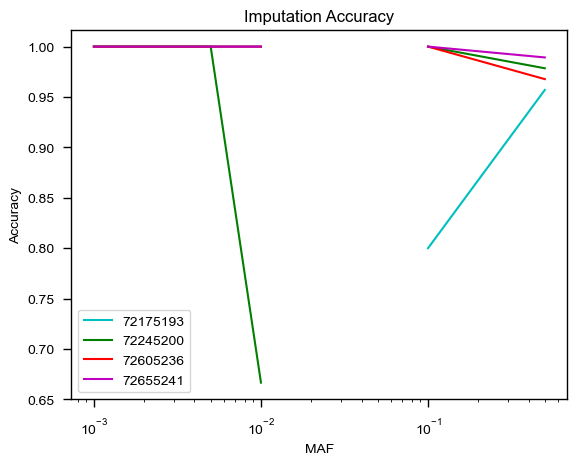

In [264]:
prop_mat = calculate_imputation_accuracy(lcwgs)
EAF_ary = np.array([0, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
plt.plot(EAF_ary, prop_mat[0,:], label = '72175193', color = 'c')
plt.plot(EAF_ary, prop_mat[1,:], label = '72245200', color = 'g')
plt.plot(EAF_ary, prop_mat[2,:], label = '72605236', color = 'r')
plt.plot(EAF_ary, prop_mat[3,:], label = '72655241', color = 'm')
plt.xlabel('MAF')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Imputation Accuracy')
plt.xscale('log')
# plt.savefig('graphs/accuracy_vs_maf.png')

---

In [125]:
def get_imputed_dosage(df, colname='call'):
    ref = df['ref']
    alt = df['alt']
    s = df[colname]
    if alt == '.' or len(alt) > 1 or len(ref) > 1:
        return pd.NaT  
    if s[:3] == '0|0' or s[:3] == '0/0':
        return pd.NaT
    else:
        return s.split(':')[2]
def get_genotype(df, colname='call'):
    ref = df['ref']
    alt = df['alt']
    s = df[colname]
    if alt == '.' or len(alt) > 1 or len(ref) > 1:
        return pd.NaT
    if s[:3] == '0|0' or s[:3] == '0/0':
        return 0
    elif s[:3] == '1|0' or s[:3] == '1/0':
        return 1
    elif s[:3] == '0|1' or s[:3] == '0/1':
        return 1
    elif s[:3] == '1|1' or s[:3] == '1/1':
        return 2
    else:
        return pd.NaT
def get_genotype_20x(df):
    return get_genotype(df, '20x')
def get_genotype_30x(df):
    return get_genotype(df, '30x')

In [126]:
for i in range(1,2):
    tmp = pd.read_csv('NA12878_1x_chr'+str(i)+'.txt', header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'attributes', 'call'],
                          dtype = {
            'chr': 'string',
            'pos': 'Int64',
            'ref': 'string',
            'alt': 'string',
            'attributes': 'string',
            'call': 'string'
        })
    tmp['dosage'] = tmp.apply(get_imputed_dosage, axis=1)
    tmp = tmp.dropna()
    tmp['dosage'] = pd.to_numeric(tmp['dosage'])
    tmp = tmp.drop(columns = ['call', 'attributes'])
    if i==1:
        NA12878_1x_vcf = tmp
    else:
        NA12878_1x_vcf = pd.concat([NA12878_1x_vcf,tmp])

NA12878_1x_vcf.head(10)

,chr,pos,ref,alt,dosage
225,chr1,17365,C,G,0.362
229,chr1,17385,G,A,0.999
339,chr1,20250,T,C,1.004
396,chr1,39230,G,A,0.952
521,chr1,57158,G,C,1.153
534,chr1,57856,T,A,0.714
561,chr1,58771,T,C,0.568
565,chr1,58866,C,G,0.494
637,chr1,61987,A,G,0.708
638,chr1,61989,G,C,0.708


In [127]:
for i in range(1,2):
    tmp = pd.read_csv('NA12878_20x_chr'+str(i)+'.txt', header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'call'],
                      dtype = {
        'chr': 'string',
        'pos': 'Int64',
        'ref': 'string',
        'alt': 'string',
        'call': 'string'
    })
    tmp['call'] = tmp.apply(get_genotype, axis=1)
    tmp = tmp.dropna()
    tmp['call'] = pd.to_numeric(tmp['call'])
    if i==1:
        NA12878_20x_vcf = tmp
    else:
        NA12878_20x_vcf = pd.concat([NA12878_20x_vcf,tmp])

NA12878_20x_vcf.head(10)

,chr,pos,ref,alt,call
9,chr1,10247,T,C,1
11,chr1,10254,T,C,1
13,chr1,10285,T,C,1
21,chr1,10327,T,C,1
35,chr1,10426,A,C,1
37,chr1,10432,A,C,1
41,chr1,10445,A,C,1
42,chr1,10451,A,C,1
43,chr1,10456,T,C,1
44,chr1,10457,A,C,1


In [138]:
NA12878_high_confidence = pd.read_csv('NA12878_high_confidence_position.txt', header = None, sep = '\t', names = ['chr', 'pos'],
                      dtype = {'chr': 'string', 'pos': 'Int64'})
NA12878_high_confidence

,chr,pos
0,chr1,17385
1,chr1,783006
2,chr1,783175
3,chr1,784860
4,chr1,785417
...,...,...
3893337,chr22,50791190
3893338,chr22,50792075
3893339,chr22,50792591
3893340,chr22,50792792


In [139]:
for i in range(1,2):
    tmp = pd.read_csv('gnomAD_MAF_chr'+str(i)+'.txt', header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'MAF'],
                      dtype = {
        'chr': 'string',
        'pos': 'Int64',
        'ref': 'string',
        'alt': 'string',
        'MAF': 'string'
    })
    tmp = tmp.dropna()
    tmp['MAF'] = pd.to_numeric(tmp['MAF'])
    if i==1:
        gnomAD_vcf = tmp
    else:
        gnomAD_vcf = pd.concat([gnomAD_vcf,tmp])

gnomAD_vcf.head(10)

,chr,pos,ref,alt,MAF
0,chr1,10037,T,C,0.000026
1,chr1,10043,T,C,0.000012
2,chr1,10055,T,C,0.000011
3,chr1,10057,A,C,0.000026
4,chr1,10111,C,A,0.000023
5,chr1,10114,T,C,0.000225
6,chr1,10126,T,A,0.000047
7,chr1,10126,T,C,0.000024
8,chr1,10126,T,G,0.000024
9,chr1,10131,C,A,0.000009


In [140]:
NA12878 = pd.merge(NA12878_1x_vcf, NA12878_20x_vcf, on=['chr', 'pos', 'ref', 'alt'], how="left")
NA12878 = pd.merge(NA12878, gnomAD_vcf, on=['chr', 'pos', 'ref', 'alt'], how="left")
NA12878 = NA12878.dropna()
NA12878_high_confidence = pd.merge(NA12878_high_confidence, NA12878, on=['chr', 'pos'], how="left")
NA12878_high_confidence = NA12878_high_confidence.dropna()

In [141]:
MAF_ary = np.array([0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
r2 = np.zeros(np.size(MAF_ary) - 1)
r2_high_confidence = np.zeros(np.size(MAF_ary) - 1)
for i in range(r2.size):
    tmp = NA12878[(MAF_ary[i+1] > NA12878['MAF']) & (NA12878['MAF'] > MAF_ary[i])]
    r2[i] = np.corrcoef(tmp['dosage'].values, tmp['call'].values)[0,1]**2
    tmp = NA12878_high_confidence[(MAF_ary[i+1] > NA12878_high_confidence['MAF']) & (NA12878_high_confidence['MAF'] > MAF_ary[i])]
    r2_high_confidence[i] = np.corrcoef(tmp['dosage'].values, tmp['call'].values)[0,1]**2

C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Sus\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Sus\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeW

Text(0.5, 1.0, 'Imputation Accuracy of the NA12878 sample')

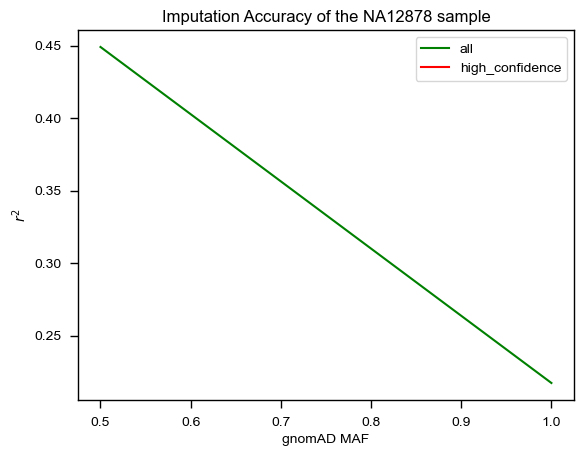

In [142]:
plt.plot(MAF_ary[1:], r2, label = 'all', color = 'g')
plt.plot(MAF_ary[1:], r2_high_confidence, label = 'high_confidence', color = 'r')
plt.xlabel('gnomAD MAF')
plt.ylabel('$r^2$')
plt.legend()
plt.title('Imputation Accuracy of the NA12878 sample')
plt.savefig('graphs/NA12878_imputation_accuracy.png', bbox_inches = "tight", dpi = 300)

___

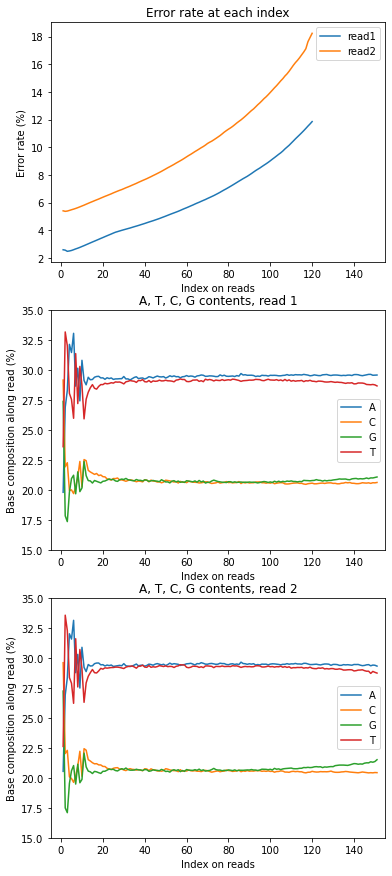

In [44]:
df1 = pd.read_csv("../results/kmer/WTCHG_975861_IDT0577/read1/WTCHG_975861_IDT0577_position1.tsv.gz", sep='\t', compression='gzip')
df1['number_of_errors'] = pd.to_numeric(df1['number_of_errors'])
df1['number_of_reads'] = pd.to_numeric(df1['number_of_reads'])
df1['A'] = pd.to_numeric(df1['A'])
df1['G'] = pd.to_numeric(df1['G'])
df1['C'] = pd.to_numeric(df1['C'])
df1['T'] = pd.to_numeric(df1['T'])
df1['error_rate'] = df1['number_of_errors']/df1['number_of_reads']
df1['percentage A'] = df1['A']/df1['number_of_reads']
df1['percentage C'] = df1['C']/df1['number_of_reads']
df1['percentage G'] = df1['G']/df1['number_of_reads']
df1['percentage T'] = df1['T']/df1['number_of_reads']
df1 = df1.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])

df2 = pd.read_csv("../results/kmer/WTCHG_975861_IDT0577/read2/WTCHG_975861_IDT0577_position2.tsv.gz", sep='\t', compression='gzip')
df2['number_of_errors'] = pd.to_numeric(df2['number_of_errors'])
df2['number_of_reads'] = pd.to_numeric(df2['number_of_reads'])
df2['A'] = pd.to_numeric(df2['A'])
df2['G'] = pd.to_numeric(df2['G'])
df2['C'] = pd.to_numeric(df2['C'])
df2['T'] = pd.to_numeric(df2['T'])
df2['error_rate'] = df2['number_of_errors']/df2['number_of_reads']
df2['percentage A'] = df2['A']/df2['number_of_reads']
df2['percentage C'] = df2['C']/df2['number_of_reads']
df2['percentage G'] = df2['G']/df2['number_of_reads']
df2['percentage T'] = df2['T']/df2['number_of_reads']
df2 = df2.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])

fig = plt.figure(figsize=(6,15))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df1['position'][:120], df1['error_rate'][:120]*100, label = 'read1')
ax1.plot(df2['position'][:120], df2['error_rate'][:120]*100, label = 'read2')
ax1.set_xlabel('Index on reads')
ax1.set_ylabel('Error rate (%)')
ax1.set_title('Error rate at each index')
ax1.set_xlim((-5,155))
ax1.legend()

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df1['position'], df1['percentage A']*100, label = 'A')
ax2.plot(df1['position'], df1['percentage C']*100, label = 'C')
ax2.plot(df1['position'], df1['percentage G']*100, label = 'G')
ax2.plot(df1['position'], df1['percentage T']*100, label = 'T')
ax2.set_xlabel('Index on reads')
ax2.set_ylabel('Base composition along read (%)')
ax2.set_title('A, T, C, G contents, read 1')
ax2.legend()
ax2.set_xlim((-5,155))
ax2.set_ylim((15,35))

ax3 = plt.subplot(3, 1, 3)
ax3.plot(df2['position'], df2['percentage A']*100, label = 'A')
ax3.plot(df2['position'], df2['percentage C']*100, label = 'C')
ax3.plot(df2['position'], df2['percentage G']*100, label = 'G')
ax3.plot(df2['position'], df2['percentage T']*100, label = 'T')
ax3.set_xlabel('Index on reads')
ax3.set_ylabel('Base composition along read (%)')
ax3.set_title('A, T, C, G contents, read 2')
ax3.legend()
ax3.set_xlim((-5,155))
ax3.set_ylim((15,35))
# plt.savefig('../graphs/fig3_number_reads_vs_concentration.png', bbox_inches = "tight", dpi=300)
plt.show()

In [7]:
metrics = pd.read_csv('../results/lcwgs_results.csv', sep = ',')
metrics['Fragment_Size'] = pd.to_numeric(metrics['Fragment_Size'])
metrics['Code'] = metrics['Code'].apply(lambda row: row.rstrip('_GTATGCCACA-GAAGACTCGG'))
metrics['Code'] = metrics['Code'].apply(lambda row: row.rstrip('_GCCAACAGAC-AACGTGAACG'))
metrics['Code'] = metrics['Code'].apply(lambda row: row.lstrip('WTCHG_975861_'))

lab_prep = pd.read_csv('../data/lab_prep/VAL0082_P230071_lcWGS_metadata_table.csv', sep = ',') 
# lab_prep = lab_prep.drop(columns = ['Name', 'Lims ID', 'Index', 'Control', 'Miniaturisation', 'Automation', 'Size Selection'])
lab_prep = lab_prep.rename(columns={'Sequencing ID': 'Code'})

whole = pd.merge(metrics, lab_prep, on='Code', how="left")
whole = whole.sort_values(by = ['Samtools_Dup_Rate'])
'''
whole['max'] = whole['Kmer_Error_Rate_Read1']
whole['label'] = whole['Method']
for i in range(whole.shape[0]):
    if whole['max'].values[i] <= max(whole['Samtools_Dup_Rate'].values[i], whole['Uncoverage'].values[i]):
        whole['max'].values[i] = max(whole['Samtools_Dup_Rate'].values[i], whole['Uncoverage'].values[i])
    whole['label'].values[i] = whole['label'].values[i][0] + str(whole['Mass Input (ng)'].values[i])
'''

# whole.to_csv('../results/lcwgs_results_with_lab_prep.csv', index=False)
whole

,Code,Kmer_Error_Rate_Read1,Kmer_Error_Rate_Read2,Fastqc_Dup_Rate,Samtools_Dup_Rate,Coverage,Uncoverage,Fragment_Size,Name,Lims ID,Index,Method,Control,Miniaturisation,Automation,Experiment,Mass Input (ng),Rep,Size Selection,PCR Cycles
19,IDT0639,0.0616,0.1304,0.0964,0.1315,3.1949,0.1134,449.4180,UIIFS_C2_MMM Manual_100_Rep1_Exp6,TRE10171A28,0598_P07_F03_IDT0639,UIIFS,C2,FV,Manual,6,100,1,MMM,6
29,IDT0604,0.0671,0.1029,0.1182,0.1319,3.3936,0.1298,291.7222,UIIFS_C3_10x Echo Pct SS_50_Rep3_Exp9,TRE10171A6,0603_P07_C04_IDT0604,UIIFS,C3,10,Echo,9,50,3,%,7
20,IDT0594,0.0618,0.0852,0.1195,0.1354,3.4595,0.1257,277.1070,UIIFS_C1_10x Manual Pct SS_10_Rep2_Exp9,TRE10171A17,0618_P07_B06_IDT0594,UIIFS,C1,10,Manual,9,10,2,%,8
64,IDU0042,0.1593,0.2053,0.1475,0.1360,7.1545,0.0567,269.0705,DNAP_C3_10x Echo_10_Rep2_Exp5b,TRE10171A52,ILMNXT_B06_UDP0042,DNAP,C3,10,Echo,5b,10,2,Original,8
31,IDT0654,0.0679,0.0820,0.1125,0.1362,3.2273,0.1572,242.7967,UIIFS_C1_MMM Manual_100_Rep1_Exp9,TRE10171A22,0623_P07_G06_IDT0654,UIIFS,C1,FV,Manual,9,100,1,MMM,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,IDU0007,0.0737,0.1393,0.1525,0.1785,5.3333,0.0692,371.7226,DNAP_C1_FV Manual_100_Rep3_Exp2,TRE10171A38,ILMNXT_G01_UDP0007,DNAP,C1,FV,Manual,2,100,3,Original,5
44,IDT0652,0.0875,0.1205,0.1386,0.1796,3.4537,0.1611,248.7511,UIIFS_C1_10x Echo Pct SS_10_Rep1_Exp9,TRE10171A10,0607_P07_G04_IDT0652,UIIFS,C1,10,Echo,9,10,1,%,8
13,IDT0072,0.0606,0.1812,0.1147,0.1799,4.3549,0.0839,480.8798,MMM-L_C1_Hulk_50_Rep1_Exp1,TRE10171A65,0094_P01_F12_IDT0072,MMM-L,C1,FV,Hulk,1,50,1,Original,10
2,IDT0631,0.0546,0.1114,0.2470,0.3434,1.2538,0.4847,362.8795,MMM-L_C3_Manual_10_Rep1_Exp2,TRE10171A63,0629_P07_E07_IDT0631,MMM-L,C3,FV,Manual,2,10,1,Original,10


In [3]:
MMML = whole[whole['Method']=='MMM-L']
UIIFS = whole[whole['Method']=='UIIFS']
DNAP = whole[whole['Method']=='DNAP']

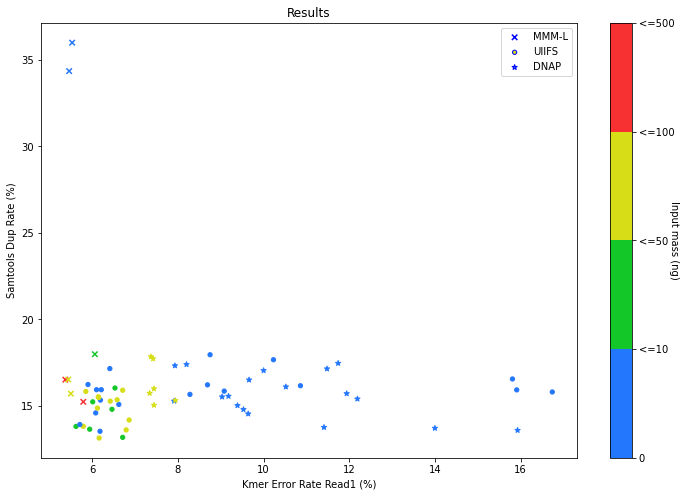

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 1, 1)
bounds1 = np.array([5, 25, 63, 250, 1000])
colors1 = ['#2377fc', '#14c729', '#d7de18', '#f73131']
cmap1 = mcolors.ListedColormap(colors1)
norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
im1 = ax1.scatter(MMML['Kmer_Error_Rate_Read1']*100, MMML['Samtools_Dup_Rate']*100, c = MMML['Mass Input (ng)'], label = 'MMM-L',
                  cmap=cmap1, norm=norm1, s=30, marker = "x")
ax1.scatter(UIIFS['Kmer_Error_Rate_Read1']*100, UIIFS['Samtools_Dup_Rate']*100, c = UIIFS['Mass Input (ng)'], label = 'UIIFS',
            cmap=cmap1, norm=norm1, s=18, marker = "o")
ax1.scatter(DNAP['Kmer_Error_Rate_Read1']*100, DNAP['Samtools_Dup_Rate']*100, c = DNAP['Mass Input (ng)'], label = 'DNAP',
            cmap=cmap1, norm=norm1, s=30, marker = "*")
ax1.set_xlabel('Kmer Error Rate Read1 (%)')
ax1.set_ylabel('Samtools Dup Rate (%)')
ax1.set_title('Results')
ax1.legend()

leg = ax1.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('blue')
leg.legendHandles[2].set_color('blue')

cbar = plt.colorbar(im1)
cbar.ax.set_yticklabels(['0', '<=10', '<=50', '<=100', '<=500'])
cbar.set_label('Input mass (ng)', rotation=270)
plt.savefig('../graphs/metrics.png', bbox_inches = "tight", dpi=300)

In [5]:
rep1 = whole[whole['Rep']==1]
rep2 = whole[whole['Rep']==2]
rep3 = whole[whole['Rep']==3]

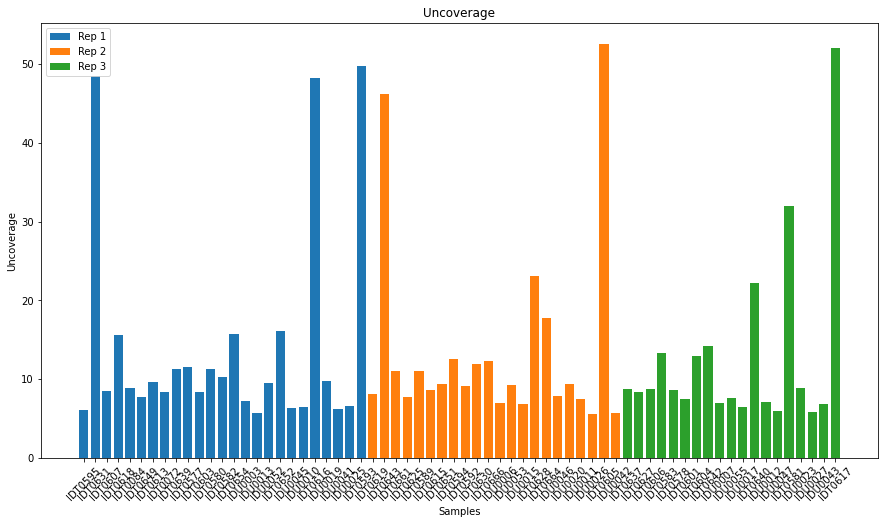

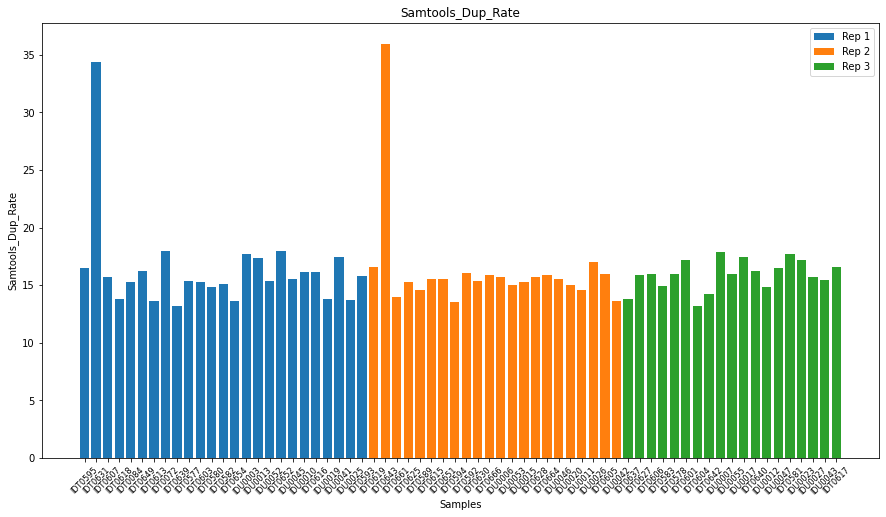

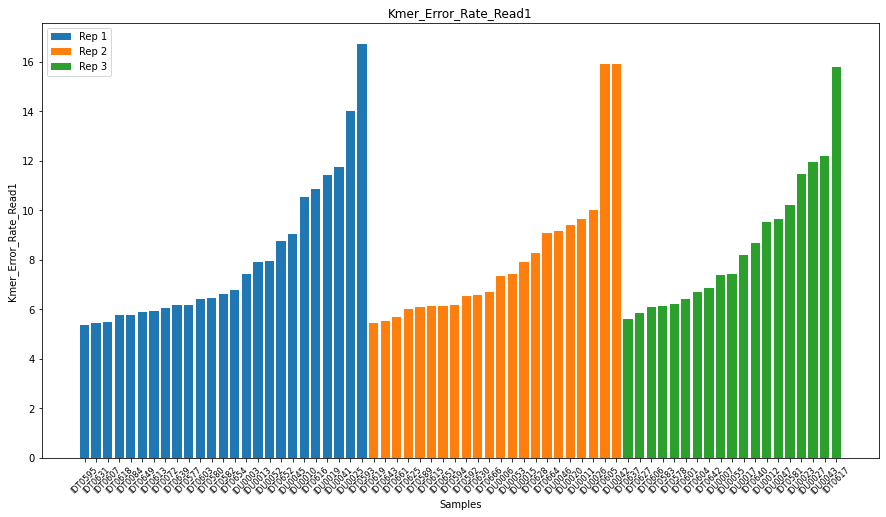

In [6]:
def plot_individual_metric(colname, sort = 'Kmer_Error_Rate_Read1', ascending = True, rep1 = rep1, rep2 = rep2, rep3 = rep3):
    fig = plt.figure(figsize=(15,8))
    rep1 = rep1.sort_values(by = [sort], ascending=ascending)
    plt.bar(rep1['Code'], rep1[colname]*100, label = 'Rep 1')
    rep2 = rep2.sort_values(by = [sort], ascending=ascending)
    plt.bar(rep2['Code'], rep2[colname]*100, label = 'Rep 2')
    rep3 = rep3.sort_values(by = [sort], ascending=ascending)
    plt.bar(rep3['Code'], rep3[colname]*100, label = 'Rep 3')
    plt.rc('xtick', labelsize=8)
    plt.xticks(rotation = 45)
    
    plt.xlabel('Samples')
    plt.ylabel(colname)
    plt.title(colname)
    plt.legend()
    
    plt.savefig('../graphs/' + colname + '.png', bbox_inches = "tight", dpi=300)
    plt.show()
    
plot_individual_metric('Uncoverage')
plot_individual_metric('Samtools_Dup_Rate')
plot_individual_metric('Kmer_Error_Rate_Read1')

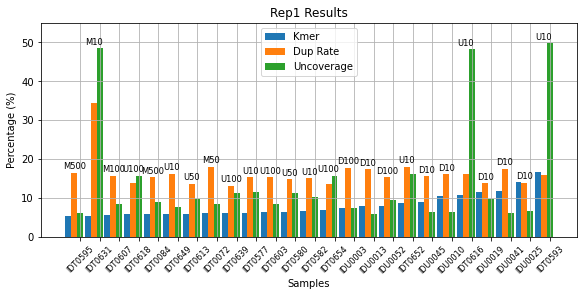

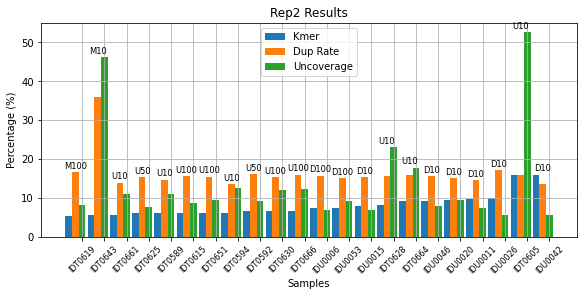

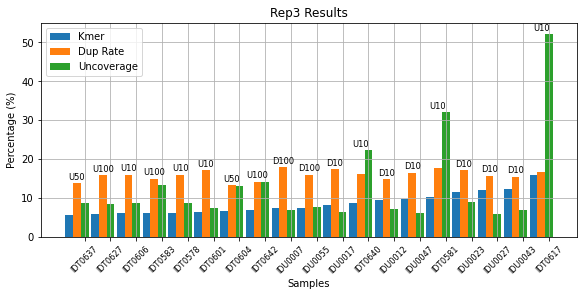

In [7]:
def plot_grouped_reps(df, rep, sort = 'Kmer_Error_Rate_Read1', width = 0.3):
    sort = sort
    width = width
    size = df.shape[0]
    x = np.arange(size)
    
    fig, ax = plt.subplots(layout='constrained', figsize=(8,4))
    df = df.sort_values(by = [sort], ascending=True)
    ax.bar(x - width, df['Kmer_Error_Rate_Read1']*100, width = width, label = 'Kmer')
    ax.bar(x, df['Samtools_Dup_Rate']*100, width = width, label = 'Dup Rate')
    ax.bar(x + width, df['Uncoverage']*100, width = width, label = 'Uncoverage')
    ax.legend()
    ax.set_xticks(x + width, df['Code'],rotation = 45)
    for i in range(df.shape[0]):
        ax.text(x[i], df['max'].values[i]*100 + 1, df['label'].values[i], ha='center', size = 'small')

    ax.set_xlabel('Samples')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(rep + ' Results')
    ax.set_ylim(0,55)
    ax.grid()
    
    plt.savefig('../graphs/' + rep + '.png', bbox_inches = "tight", dpi=300)
    plt.show()

plot_grouped_reps(rep1, 'Rep1')
plot_grouped_reps(rep2, 'Rep2')
plot_grouped_reps(rep3, 'Rep3')

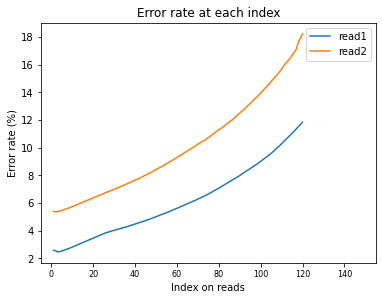

In [9]:
df1 = pd.read_csv("../results/kmer/WTCHG_975861_IDT0577/read1/WTCHG_975861_IDT0577_position1.tsv.gz", sep='\t', compression='gzip')
df1['number_of_errors'] = pd.to_numeric(df1['number_of_errors'])
df1['number_of_reads'] = pd.to_numeric(df1['number_of_reads'])
df1['A'] = pd.to_numeric(df1['A'])
df1['G'] = pd.to_numeric(df1['G'])
df1['C'] = pd.to_numeric(df1['C'])
df1['T'] = pd.to_numeric(df1['T'])
df1['error_rate'] = df1['number_of_errors']/df1['number_of_reads']
df1['GC'] = (df1['G'] + df1['C'])/df1['number_of_reads']
df1 = df1.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])

df2 = pd.read_csv("../results/kmer/WTCHG_975861_IDT0577/read2/WTCHG_975861_IDT0577_position2.tsv.gz", sep='\t', compression='gzip')
df2['number_of_errors'] = pd.to_numeric(df2['number_of_errors'])
df2['number_of_reads'] = pd.to_numeric(df2['number_of_reads'])
df2['A'] = pd.to_numeric(df2['A'])
df2['G'] = pd.to_numeric(df2['G'])
df2['C'] = pd.to_numeric(df2['C'])
df2['T'] = pd.to_numeric(df2['T'])
df2['error_rate'] = df2['number_of_errors']/df2['number_of_reads']
df2['GC'] = (df2['G'] + df2['C'])/df2['number_of_reads']
df2 = df2.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])

fig = plt.figure(figsize=(6,15))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df1['position'][:120], df1['error_rate'][:120]*100, label = 'read1')
ax1.plot(df2['position'][:120], df2['error_rate'][:120]*100, label = 'read2')
ax1.set_xlabel('Index on reads')
ax1.set_ylabel('Error rate (%)')
ax1.set_title('Error rate at each index')
ax1.set_xlim((-5,155))
ax1.legend()

# ax2 = plt.subplot(3, 1, 2)
# ax2.plot(df1['position'], df1['percentage A']*100, label = 'A')
# ax2.plot(df1['position'], df1['percentage C']*100, label = 'C')
# ax2.plot(df1['position'], df1['percentage G']*100, label = 'G')
# ax2.plot(df1['position'], df1['percentage T']*100, label = 'T')
# ax2.set_xlabel('Index on reads')
# ax2.set_ylabel('Base composition along read (%)')
# ax2.set_title('A, T, C, G contents, read 1')
# ax2.legend()
# ax2.set_xlim((-5,155))
# ax2.set_ylim((15,35))

# ax3 = plt.subplot(3, 1, 3)
# ax3.plot(df2['position'], df2['percentage A']*100, label = 'A')
# ax3.plot(df2['position'], df2['percentage C']*100, label = 'C')
# ax3.plot(df2['position'], df2['percentage G']*100, label = 'G')
# ax3.plot(df2['position'], df2['percentage T']*100, label = 'T')
# ax3.set_xlabel('Index on reads')
# ax3.set_ylabel('Base composition along read (%)')
# ax3.set_title('A, T, C, G contents, read 2')
# ax3.legend()
# ax3.set_xlim((-5,155))
# ax3.set_ylim((15,35))
# # plt.savefig('../graphs/fig3_number_reads_vs_concentration.png', bbox_inches = "tight", dpi=300)
# plt.show()

In [10]:
import glob

df_dict1 = {}
df_dict2 = {}

path1 = "../results/kmer/WTCHG_975861_*/read1/WTCHG_975861_*_position1.tsv.gz"
path2= "../results/kmer/WTCHG_975861_*/read2/WTCHG_975861_*_position2.tsv.gz"
for filename in glob.glob(path1):
    code = filename.split("/read1/")[0].replace('../results/kmer/WTCHG_975861_', '')
    if '_' in code:
        code = code.split('_')[0]
    df = pd.read_csv(filename, sep='\t', compression='gzip')
    df['number_of_errors'] = pd.to_numeric(df['number_of_errors'])
    df['number_of_reads'] = pd.to_numeric(df['number_of_reads'])
    df['A'] = pd.to_numeric(df['A'])
    df['G'] = pd.to_numeric(df['G'])
    df['C'] = pd.to_numeric(df['C'])
    df['T'] = pd.to_numeric(df['T'])
    df['error_rate'] = df['number_of_errors']/df['number_of_reads']
    df['GC'] = (df['G'] + df['C'])/df['number_of_reads']
    df = df.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])
    df_dict1[code] = df
for filename in glob.glob(path2):
    code = filename.split("/read2/")[0].replace('../results/kmer/WTCHG_975861_', '')
    if '_' in code:
        code = code.split('_')[0]
    df = pd.read_csv(filename, sep='\t', compression='gzip')
    df['number_of_errors'] = pd.to_numeric(df['number_of_errors'])
    df['number_of_reads'] = pd.to_numeric(df['number_of_reads'])
    df['A'] = pd.to_numeric(df['A'])
    df['G'] = pd.to_numeric(df['G'])
    df['C'] = pd.to_numeric(df['C'])
    df['T'] = pd.to_numeric(df['T'])
    df['error_rate'] = df['number_of_errors']/df['number_of_reads']
    df['GC'] = (df['G'] + df['C'])/df['number_of_reads']
    df = df.drop(columns = ['start_or_end', 'sum_of_base_qualities', 'number_of_reads', 'number_of_errors', 'A', 'G', 'C', 'T'])
    df_dict2[code] = df

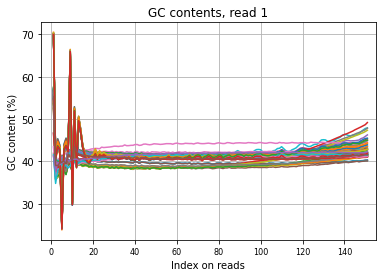

In [11]:
ax1 = plt.subplot()
for keys in df_dict1.keys():
    ax1.plot(df_dict1[keys]['position'], df_dict1[keys]['GC']*100, label = keys + '_read1')
ax1.set_xlabel('Index on reads')
ax1.set_ylabel('GC content (%)')
ax1.set_title('GC contents, read 1')
ax1.set_xlim((-5,155))
ax1.grid()
plt.savefig('../graphs/GC_content1.png', bbox_inches = "tight", dpi=300)

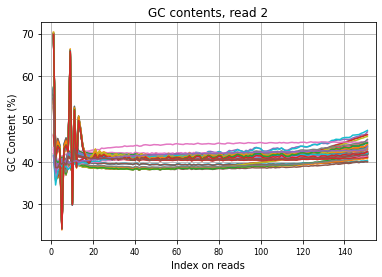

In [12]:
ax2= plt.subplot()
for keys in df_dict2.keys():
    ax2.plot(df_dict2[keys]['position'], df_dict2[keys]['GC']*100, label = keys + '_read2')
ax2.set_xlabel('Index on reads')
ax2.set_ylabel('GC Content (%)')
ax2.set_title('GC contents, read 2')
ax2.set_xlim((-5,155))
ax2.grid()
plt.savefig('../graphs/GC_content2.png', bbox_inches = "tight", dpi=300)

In [21]:
kmer1 = pd.read_csv('../results/kmer/kmer_accuracy_read1.txt', sep = '\t', 
                   names = ['Code', 'Kmer_Error_Rate_Read1'], dtype = {'Code': 'string', 'Kmer_Error_Rate_Read1': 'float'})
kmer2 = pd.read_csv('../results/kmer/kmer_accuracy_read2.txt', sep = '\t', 
                   names = ['Code', 'Kmer_Error_Rate_Read2'], dtype = {'Code': 'string', 'Kmer_Error_Rate_Read2': 'float'})
fastqc = pd.read_csv('../results/fastqc/duplication_rate_fastqc.txt', sep = '\t', 
                   names = ['Code', 'Fastqc_Dup_Rate'], dtype = {'Code': 'string', 'Fastqc_Dup_Rate': 'float'})
samtools = pd.read_csv('../results/dup_rate/duplication_rate_samtools.txt', sep = '\t', 
                   names = ['Code', 'Samtools_Dup_Rate'], dtype = {'Code': 'string', 'Samtools_Dup_Rate': 'float'})
coverage = pd.read_csv('../results/coverage/per_sample_coverage.txt', sep = ' ', 
                   names = ['Code', 'Coverage'], dtype = {'Code': 'string', 'Coverage': 'float'})
uncoverage = pd.read_csv('../results/coverage/per_chromosome_coverage/uncoverage_rate.txt', sep = ' ', 
                   names = ['Code', 'Uncoverage'], dtype = {'Code': 'string', 'Uncoverage': 'float'})
ss_uncoverage = pd.read_csv('../results/coverage/per_chromosome_ss_coverage/ss_uncoverage_rate.txt', sep = ' ', 
                   names = ['Code', 'Subsampled_Uncoverage'], dtype = {'Code': 'string', 'Subsampled_Uncoverage': 'float'})
fragment_size = pd.read_csv('../results/fragment_size/fragment_size.txt', sep = '\t', 
                   names = ['Code', 'Fragment_Size'], dtype = {'Code': 'string', 'Fragment_Size': 'float'})
metrics = pd.merge(kmer1, kmer2, on='Code', how="left")
metrics = pd.merge(metrics, fastqc, on='Code', how="left")
metrics = pd.merge(metrics, samtools, on='Code', how="left")
metrics = pd.merge(metrics, coverage, on='Code', how="left")
metrics = pd.merge(metrics, uncoverage, on='Code', how="left")
metrics = pd.merge(metrics, ss_uncoverage, on='Code', how="left")
metrics = pd.merge(metrics, fragment_size, on='Code', how="left")
metrics['Code'] = metrics['Code'].apply(lambda row: row.rstrip('_GTATGCCACA-GAAGACTCGG'))
metrics['Code'] = metrics['Code'].apply(lambda row: row.rstrip('_GCCAACAGAC-AACGTGAACG'))
metrics['Code'] = metrics['Code'].apply(lambda row: row.lstrip('WTCHG_975861_'))

lab_prep = pd.read_csv('../data/lab_prep/VAL0082_P230071_lcWGS_metadata_table.csv', sep = ',') 
# lab_prep = lab_prep.drop(columns = ['Name', 'Lims ID', 'Index', 'Control', 'Miniaturisation', 'Automation', 'Size Selection'])
lab_prep = lab_prep.rename(columns={'Sequencing ID': 'Code'})
whole = pd.merge(metrics, lab_prep, on='Code', how="left")

weight = np.hstack((np.ones(60), np.arange(1,7)))

whole['metric'] = whole['Kmer_Error_Rate_Read1'].rank(ascending=True)*weight + whole['Kmer_Error_Rate_Read2'].rank(ascending=True)*weight + whole['Subsampled_Uncoverage'].rank(ascending=True)*weight + whole['Samtools_Dup_Rate'].rank(ascending=True)*weight
whole = whole.sort_values(by = ['metric'])
whole = whole.iloc[:60,:]

# '''
# whole['max'] = whole['Kmer_Error_Rate_Read1']
# whole['label'] = whole['Method']
# for i in range(whole.shape[0]):
#     if whole['max'].values[i] <= max(whole['Samtools_Dup_Rate'].values[i], whole['Uncoverage'].values[i]):
#         whole['max'].values[i] = max(whole['Samtools_Dup_Rate'].values[i], whole['Uncoverage'].values[i])
#     whole['label'].values[i] = whole['label'].values[i][0] + str(whole['Mass Input (ng)'].values[i])
# '''
whole = pd.get_dummies(whole, columns=['Method', 'Miniaturisation', 'Automation', 'Mass Input (ng)', 'Rep', 'Size Selection', 'Experiment'], drop_first=True)
whole

# whole.to_csv('../results/lcwgs_results_with_lab_prep.csv', index=False)

,Code,Kmer_Error_Rate_Read1,Kmer_Error_Rate_Read2,Fastqc_Dup_Rate,Samtools_Dup_Rate,Coverage,Uncoverage,Subsampled_Uncoverage,Fragment_Size,Name,...,Rep_3,Size Selection_MMM,Size Selection_Original,Experiment_2,Experiment_3,Experiment_4,Experiment_5,Experiment_5b,Experiment_6,Experiment_9
39,IDT0661,0.0571,0.0924,0.1030,0.1393,3.5045,0.1098,0.4169,347.2192,UIIFS_C1_MMM Echo_10_Rep2_Exp6,...,0,1,0,0,0,0,0,0,1,0
30,IDT0637,0.0562,0.1091,0.1037,0.1382,4.0195,0.0870,0.4082,377.7093,UIIFS_C1_MMM Echo_50_Rep3_Exp6,...,1,1,0,0,0,0,0,0,1,0
31,IDT0639,0.0616,0.1304,0.0964,0.1315,3.1949,0.1134,0.4043,449.4180,UIIFS_C2_MMM Manual_100_Rep1_Exp6,...,0,1,0,0,0,0,0,0,1,0
19,IDT0613,0.0594,0.1342,0.0986,0.1366,3.7293,0.0962,0.4105,370.4704,UIIFS_C1_MMM Echo_50_Rep1_Exp6,...,0,1,0,0,0,0,0,0,1,0
18,IDT0607,0.0550,0.0933,0.1295,0.1571,4.1915,0.0853,0.4133,368.7780,MMM-L_C3_Manual_100_Rep1_Exp2,...,0,0,1,1,0,0,0,0,0,0
25,IDT0625,0.0601,0.1058,0.1147,0.1524,4.4707,0.0778,0.4083,378.5001,UIIFS_C1_MMM Echo_50_Rep2_Exp6,...,0,1,0,0,0,0,0,0,1,0
23,IDT0618,0.0579,0.0785,0.1231,0.1383,3.1308,0.1565,0.4763,257.0557,UIIFS_C3_MMM Manual_100_Rep1_Exp9,...,0,1,0,0,0,0,0,0,0,1
24,IDT0619,0.0544,0.0830,0.1349,0.1653,4.3526,0.0813,0.4123,373.2096,MMM-L_C3_Manual_100_Rep2_Exp2,...,0,0,1,1,0,0,0,0,0,0
11,IDT0594,0.0618,0.0852,0.1195,0.1354,3.4595,0.1257,0.4593,277.1070,UIIFS_C1_10x Manual Pct SS_10_Rep2_Exp9,...,0,0,0,0,0,0,0,0,0,1
8,IDT0589,0.0608,0.0984,0.1115,0.1460,3.8147,0.1099,0.4485,283.6821,UIIFS_C1_10x FAST_10_Rep2_Exp5,...,0,1,0,0,0,0,1,0,0,0


In [14]:
whole[['metric', 'Method', 'Miniaturisation', 'Automation', 'Experiment','Mass Input (ng)', 'Size Selection', 'PCR Cycles']].head(30)

KeyError: "['Method', 'Miniaturisation', 'Automation', 'Experiment', 'Mass Input (ng)', 'Size Selection'] not in index"

In [58]:
whole.columns

Index(['Code', 'Kmer_Error_Rate_Read1', 'Kmer_Error_Rate_Read2',
       'Fastqc_Dup_Rate', 'Samtools_Dup_Rate', 'Coverage', 'Uncoverage',
       'Subsampled_Uncoverage', 'Name', 'Lims ID', 'Index', 'Control',
       'PCR Cycles', 'metric', 'Method_MMM-L', 'Method_UIIFS',
       'Miniaturisation_20', 'Miniaturisation_FV', 'Automation_FAST',
       'Automation_Hulk', 'Automation_Manual', 'Mass Input (ng)_50',
       'Mass Input (ng)_100', 'Mass Input (ng)_500', 'Rep_2', 'Rep_3',
       'Size Selection_MMM', 'Size Selection_Original', 'Experiment_2',
       'Experiment_3', 'Experiment_4', 'Experiment_5', 'Experiment_5b',
       'Experiment_6', 'Experiment_9'],
      dtype='object')

In [19]:
import statsmodels.api as sm

X = whole[['Method_MMM-L', 'Method_UIIFS', 'Miniaturisation_20', 'Miniaturisation_FV', 'Automation_FAST', 'PCR Cycles',
       'Automation_Hulk', 'Automation_Manual', 'Mass Input (ng)_50',
       'Mass Input (ng)_100', 'Mass Input (ng)_500', 'Size Selection_MMM', 'Size Selection_Original', 'Fragment_Size']]
y = whole['metric']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

# results.summary()

beta = pd.DataFrame(results.params, columns=['beta'])
beta['variables'] = beta.index
pvalue = pd.DataFrame(results.pvalues, columns=['p-value'])
pvalue['variables'] = beta.index
tmp = pd.merge(beta, pvalue)
tmp = tmp[tmp['p-value'] < 0.1]
tmp

,beta,variables,p-value
0,471.326378,const,0.000121
6,-34.235617,PCR Cycles,0.013692
8,-42.839530,Automation_Manual,0.001329
9,-71.183168,Mass Input (ng)_50,0.000298
10,-43.139234,Mass Input (ng)_100,0.075644
11,-83.321144,Mass Input (ng)_500,0.002634
13,47.211039,Size Selection_Original,0.035732
14,-0.153689,Fragment_Size,0.071251


In [119]:
import statsmodels.api as sm

res = []

for i in ['Kmer_Error_Rate_Read1', 'Samtools_Dup_Rate', 'Subsampled_Uncoverage', 'Kmer_Error_Rate_Difference']:

    X = whole[['Method_MMM-L', 'Method_UIIFS', 'Miniaturisation_20', 'Miniaturisation_FV', 'Automation_FAST',
           'Automation_Hulk', 'Automation_Manual', 'Mass Input (ng)_50',
           'Mass Input (ng)_100', 'Mass Input (ng)_500', 'Rep_2', 'Rep_3',
           'Size Selection_MMM', 'Size Selection_Original']]  # Include only the relevant columns
    y = whole[i]

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    beta = pd.DataFrame(results.params, columns=['beta'])
    beta['variables'] = beta.index
    pvalue = pd.DataFrame(results.pvalues, columns=['p-value'])
    pvalue['variables'] = beta.index
    tmp = pd.merge(beta, pvalue)

    tmp = tmp[tmp['p-value'] < p_threshold]
    res.append(tmp)

,beta,variables,p-value
0,0.065916,const,0.000043
1,-0.034382,Method_MMM-L,0.004765
2,-0.043424,Method_UIIFS,0.001033
5,0.018116,Automation_FAST,0.045122
6,0.050973,Automation_Hulk,0.003663
